# Выполнил: Серегин М.С

<h1>Задание</h1>
<b>Построение модели потребления</b>
<ul>
<li>Нужно сгенерировать синтетический набор товаров (не менее 20), которые содержат закупочную цену и цену.</li>
<li>Нужно построить несколько (не менее 5) моделей поведения потребителей (МПП), которые принимают решения о покупке товаров (и количества единиц) из набора синтетических правил ("решающих деревьев") на основе цен. Модели должны быть стохастическими и выдавать полный вектор спроса. Также хотя бы в некоторых моделях должно быть решение на основе сравнения цены одного товара с другим.</li>
<li>Построить модель ("большая модель"), на вход которой поступают МПП и их доли в общем количестве, и параметры N - общее число покупателей</li>
<li>Постройте функцию, которая любым алгоритмом ("аналитически", методом случайного поиска и т.д.) точный <b>оптимум прибыли по ценам</b> большой модели при фиксированном распределении долей МПП.</li>
<li><b>Важно:</b> Протестируйте оптимум при разном распределении долей МПП. Оптимум должен изменяться. Если этого не происходит - нужно переделать МПП, так чтобы это происходило.</li>
<li>Зафиксируйте N и доли покупателей.</li>  
<li>Сгенерируйте несколько 3-5 точек для старта алгоритма, которые далее всегда будут использоваться.</li>
</ul>
<b>Задание 1:</b>
<ol>
<li>Постройте "наивный" алгоритм (см. ДЗ№1), который будет находить оптимум по каждому товару, считая, что все товары независимые. Найдите оптимум за 10, 20, 30, 40 итераций. (В каждую итерацию можно изменять все цены.)</li>
<li>Постройте алгоритм основанный "бандитах". Для 10, 20, 30, 40 итераций.</li>
<li>Сравните "наивный" алгоритм и "бандитский" по скорости, точности нахождения оптимума, а также по траектории (суммарная прибыль).</li>
</ol>
<b>Задание 2:</b> Сделайте все тоже самое как в задании 1, только на каждой итерации случайным образом меняйте +-5% меняйте доли покупателей.
<b>Задание 3:</b> Сделайте все тоже самое как в задании 1, только на каждой итерации случайным образом меняйте +-5% меняйте доли покупателей. А также меняйте N +-10% на каждой итерации.

In [1766]:
import numpy as np 
import matplotlib.pyplot as plt
import tqdm

# Построение среды

## Агенты

В среде 5 видов агентов\
**Профили агентов**
1. "Звезда". Покупки звезд влияют на спрос обычных агентов. Обычные люди склонны потреблять то, что потребляет его референтная группа. Напротив, звезда желает отдалиться от обычных людей, придумывая новые тенденции в моде. Таким образом, спрос на товары, которые потребляют обычные люди будет понижаться. Спрос на дорогие товары будет высоким (среди каннибализирующих скорее выберет наиболее дорогой). Симулируем теоретическое положение из социологии моды Зиммеля. 
2. Коллекционеры. В группе канибализирующих товаров покупает товары с примерно равной долей, зависимость от цен невысокая. 
2. Независимые агенты. Действуют независимо от других агентов
3. Обычные, на спрос которых влияет звезды. 
4. Бедные слои. В группе канибализирующих товаров покупают самый дешевый. Преимущественно покупают дешевые товары, от дорогих стараются отказываться. 

**Бюджеты агентов** \
У каждого типа агента имеются собственные бюджетные ограничения. 

1. Звезда имеет наибольший бюджет (8)
2. Коллекционеры - выше среднего (6)
3. Независимые - средний (5)
4. Обычные - ниже среднего (4)
5. Бедные - низкий (3)

Бюджетные ограничения также выбираются для каждого типа агента случайно из равномерного распределения с матожиданием, указанным выше и границами в 0.2*E, E  - матожидание



Каждый агент представляет из себя набор функций спроса на товары. 

**Стабильность поведения агентов**

Характеристика показывает, насколько высокой дисперсией обладает функция спроса агента в зависимости от типа. Спрос умножается на случайный коэффициент из равномерного распределения:
1. Звезды - средняя стохастичность $\sim [0.9,1.1]$ - гонорары, прибыль и т.д. у таких агентов не слишком стабильные
2. Коллекционеры - наименее стохастичное поведение $\sim [0.98, 1.02]$
3. Независимые - средняя стохастичность $\sim [0.92,1.08]$
4. Обычные - стохастчность выше среднего $\sim [0.87, 1.13]$
5. Бедные - крайне нестабильное поведение. Симулируем перебои с получкой, и наоборт неожиданные выручки этого слоя $\sim [0.8, 1.2]$


## Социальная структура 


В работе используется два вида структуры неравенства - пирамидальная и ромбовидная. Первая присуща странам с большой долей неравенства (например, Россия), вторая развитым странм (США, страны ЕС, некоторые другие). После выбора типа общества доли агентов выбираются случайно из равномерного распределения со следующими матожиданиями. 


Пирамидальная/Ромбовидная в %
1. Звезды -        10/5
2. Коллекционеры - 8/5
3. Независимые -   15/35
4. Обычные -       30/45
5. Бедные -        50/10

Интервал для равномерного распределения выбирается следующим образом: $[uniform(-E, 0) * 0.2 + E, uniform(0, E) * 0.2 + E]$,
E - матожидание. 

Процедура получения целых значений для агентов каждой категории, производиться процедура софтмакса, затем для каждой категории значение округляется. В случае недостаточного или излишнего количества агентов (не более 4 всего), компенсируется бедными (принудительным увеличением, либо уменьшением).

#### К сожалению не успел исследовать обе структуры. В работе используется только Ромбовидная.

## Товары

Среди товаров есть следующие категории:
1. Товары заменители (g_can)  (количество: 25%). 3 группы товаров.  В одной группе все товары канибализируют друг друга
3. Обычные (g_base)  (количество: 35%). Не имеют какой-либо особенности (за исключением случая 2).
4. Товары длительного пользования (g_longuse)  (количество:15%).
5. Товары Гиффена (g_gif)  (количество:5%).
6. Услуги, от которых при необходимости можно отказаться (туризм, развлечения, подписки, т.д.) (g_service)  (количество:15%)

Среди товаров длительного пользования есть якоря (7% от всех товаров), обладающие гало-эффектом. Каждый оказывает влияние на 4% обычных товаров (не менее одного), спрос на которые повышается при выборе товара якоря. 
В зависимости от типа товаров имеются разные функции спроса

1. Канибализирующиеся товары - быстро убывающая по мере роста цены сигмоида
2. Обычные товары - линейный спрос
3. Якоря имеют экспоненциальную функцию спроса
4. Товары длительного пользования (стиральные машины, автомобили и т.д.) обладают свойством плавного снижения спроса при повышении цены и резкого сокращения покупок при достижении какого-то неприемлемого порога. Функция - квази-сигмоида.
5. Товары Гиффена имеют параболическую функцию спроса
6. Услуги, от которых при необходимости можно отказаться


Каждый товар имеет имманентные параметры, которые задаются ограничениями. Однако для каждого агента параметры функции выбираются случайно исходя из имманентных ограничений. Таким образом достигается, во-первых, учет свойств товара, во-вторых, уникальность агента. \
Например, линейная функция спроса $Q(p) = -ax+b$ имеет один имманентный параметр - эластичность товара, который показывает скорость отказа от продукта по мере роста его стоимости. Второй не зависит от товара, а отражает бюджет агента. К каждой функции спроса границы имманентных параметров прописываются отдельно. 

### Обычные товары. 
Функция спроса - линейная. Обычные товары не имеют особых внешних воздействий, спрос на них понижается линейно.
$$Q(p) = -ax + b$$ 
$a \sim [0.4,2]$- эластичность товара для конкретного агента показывает, насколько быстро он готов перестать потреблять это благо.



b - бюджет покупателя

### Каннибализирующие спрос товары
Эти товары можно заменить другими. Функция спроса - быстроубывающая показательная. \
$$Q(p) = qz^{\left(x\right)}+\frac{b}{x}\ -\ \log\left(x\right)$$ \
$q \sim [2,5]$ \
$z \sim [0.3, 0.8]$ - оба параметра отвчают за скорость падения спроса на товар по мере увеличения стоимости \
b - бюджет агента


### Товары Гиффена
Спрос на такие товары повышается при увеличении на них цен, но при достижении какого-то порога быстро снижается. Спрос описывается параболической функцией спроса 
$$ Q(p) = -g\left(x-1\right)^{2}+ix\ +\ b$$

$g \sim [0.4, 2]$, \
$i \sim [0,1.5]$,\
b - бюджет агента



### Услуги, от которых можно отказаться
Спрос на услуги более менее эластичен для невысоких цен, наоборт спрос сильно снижается, если цена превосходит наши ожидания. Агенты склонны отказатся от покупки

$$ Q(p) = -e^{\left(a\cdot\left(p-4\right)+c\right)}+b/2$$ 

$a \sim [1,2]$ \
$c \sim [0, 2]$ оба параметра отвечают за порог, после которого спрос будет сильно снижаться, и интенсивность снижения спроса. \
b - бюджет агента

### Товары длительного пользования
Спрос понижается медленно до некоторого порога, после которого  резко падает.
$$Q(p) = \frac{w}{1+e^{\left(\left(p-4 \right)\cdot v\right)}}+\frac{b}{p+0.2}\ -\ \log\left(p+3\right)$$ \
$w \sim [1,5]$ отвечает за скорость убывания спроса до достижения порога \
$ v \sim [0.1, 10]$ отвечает за крутость обрыва спроса после достижения порога \
b - бюджет агента

In [239]:
class DemandFunctions:
    def __init__(self,):
        pass
    def g_base(self, budget):
        a = np.random.uniform(0.4,2,1)
        prime_func = lambda p: -a*p + budget
        return prime_func
        
    def g_can(self, budget):
        q = np.random.uniform(2,5,1)
        z = np.random.uniform(0.3,0.8,1)
        prime_func = lambda p: q * z ** p + budget / (p+1) - np.log(p+2)

        return prime_func
    
    
    def g_gif(self, budget):
        g = np.random.uniform(0.4,2,1)
        i = np.random.uniform(0.,1.5,1)
        prime_func = lambda p: - g * (p-1)**2 + i * p + budget
        return prime_func
    
    def g_longuse(self, budget):
        w = np.random.uniform(2,4,1)
        v = np.random.uniform(3,12,1)
        prime_func = lambda p: w / (1 + np.exp(v * (p-4))) + budget/(p+0.2) - np.log(p+3)
        return prime_func
    
    def g_service(self, budget):
        a = np.random.uniform(0.2,1,1)
        c = np.random.uniform(0,1,1)
        prime_func = lambda p:-np.exp(a*(p-4) + c)+ budget/2
        return prime_func
    
    def d_func(self, good_type, name,budget):
        """
        agent_name for noise and budget constraints 
        """

        
        noise_constraints = NOISE_DEMAND[name]
        
        prime_func =  eval(f'self.{good_type}(budget={budget})')
        
        return reduction_threshold(noise_decorator(demand_drop(prime_func, name), noise_constraints))
        
        
        

### Графики спроса для товаров .

In [1329]:
def demand_drop(func, name):
    price_after = DROP_DEMAND[name] * float(np.random.uniform(0.7,1.1,1))
    drop_scale = DROP_SCALE[name] * float(np.random.uniform(3,10,1))
    drop_value = float(np.random.uniform(0.5,2,1))
    
    def wrapper(p):
        sigmoid = lambda price_after,drop_scale: drop_value / (1 + np.exp(-drop_scale * (p - price_after)))
        return max(func(p) - sigmoid(price_after,drop_scale) + 3*sigmoid(-price_after-0.5,drop_scale/5),0)
    return wrapper
        
    

In [2032]:
def noise_decorator(func,constraints):
    
    def wrapper(*args):
        return min(func(*args)*np.random.uniform(constraints[0]*0.99, constraints[1]*1.01, 1), 20)
    
    return wrapper

In [2033]:
def reduction_threshold(func):
    def wrapper(p):
        a = float(np.random.uniform(0.1,1,1))
        sigmoid_threshold = min(-1/(1+np.exp(-a*(p - 11))) + 1, 1)
        return func(p) * sigmoid_threshold
    return wrapper

In [2034]:
def plot_demand(func, idx, title,legend):
    ax = plt.subplot(3,2, idx)
    p = np.linspace(0.5, 20, 100)
    q = list()
    for pr in p:
        q.append(func(pr))
        
    plt.plot(p, q,label=legend)
    plt.title(title)
    plt.legend()

In [2035]:
Dem = DemandFunctions()

### Без шума

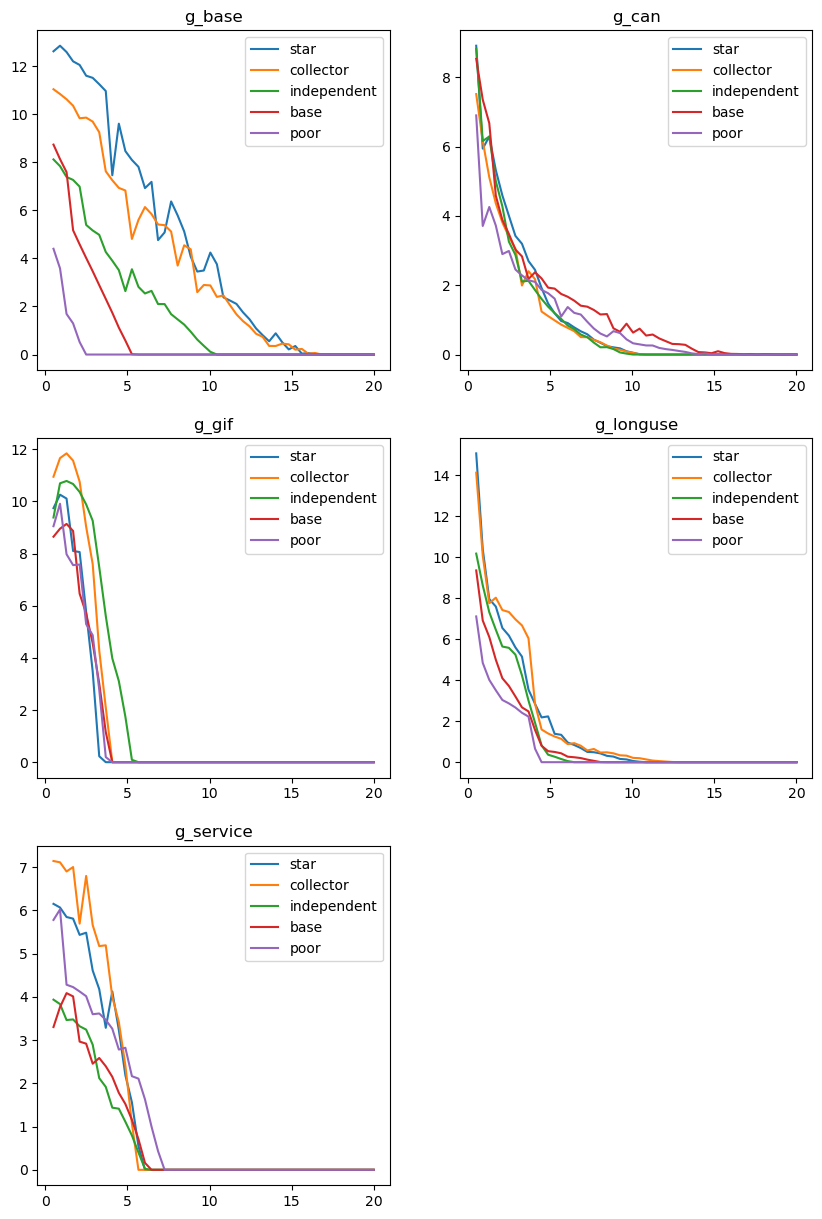

In [1010]:
plt.figure(figsize=(10,15))
for idx in range(5):
    for name in BUDGET.keys():
        plot_demand(Dem.d_func(GOODS_TYPE[idx],name, BUDGET[name]), idx+1,GOODS_TYPE[idx], legend=name)



### С шумом, отражающим нестабильность агента

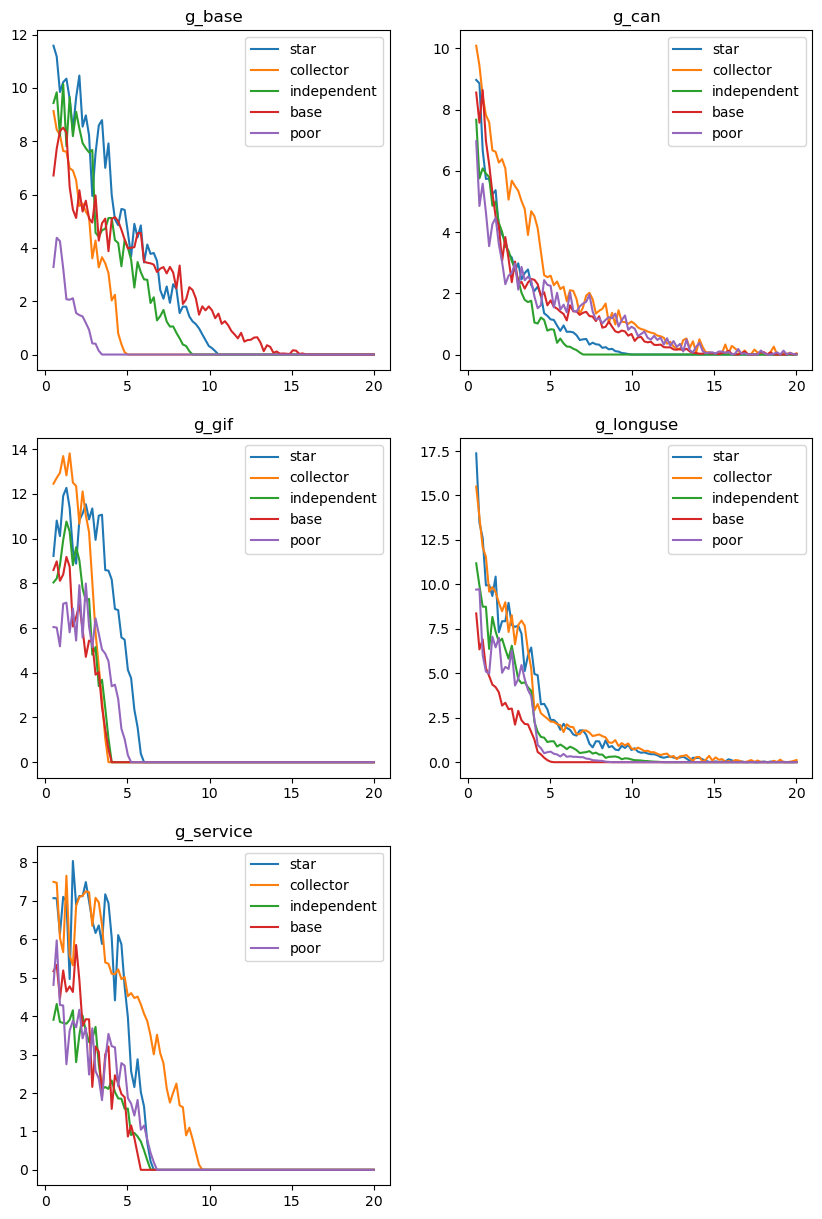

In [2036]:
plt.figure(figsize=(10,15))
for idx in range(5):
    for name in BUDGET.keys():
        plot_demand(Dem.d_func(GOODS_TYPE[idx],name, BUDGET[name]), idx+1,GOODS_TYPE[idx], legend=name)

## Процедура формирования спроса

Совокупный спрос есть сумма индивидуальных с некотороми модификациями. 

Индивидуальный спрос учитывает гало-эффект и эффект падения спроса от каннибализации товаров, любимый и нелюбимый товары агента.

После получения совокупного спроса, применяются следующие операции:
1. Увеличение спроса на товары, которые потребляют звезды. Спрос увеличивается у обычных людей
2. Уменьшение/увеличение спроса на товары, которые потребляют/не потребляют обычные и бедные люди. Спрос уменьшается/увеличивается у звезд. 
3. Увеличение/уменьшение спроса на товары, которые были отлично/ужасно прорекламированы. Такие товары выбираются случайно на каждой итерации. 

In [417]:
class Goods(DemandFunctions):
    def __init__(self,):
        super().__init__()
        
    def cannibal_decay(self,init_demand, prices, inds, decay_factor):
        """
        Decay of demand for goods with high price
        Increasing of demand for good with low price
        
        softmax is used for reduction. Then demand each good is forming accorgind to the following rule:
        value of softmax * gross demand for group (d_good1 + d_good2 + ...)
        """

        group_prices = prices[inds]
        
        softmax = np.exp(group_prices * decay_factor) / np.exp(group_prices * decay_factor).sum()
        
        gross_demand = init_demand[inds].sum()
        
        init_demand[inds] = softmax * gross_demand
        
        return init_demand
    
    
    def galo_effect(self,init_demand, galo_ind, dependent_inds):
        """
        Increase demand for goods with galo effect related to galo good
        
        Demand for dependent good is increasing by galo_factor * demand_of_galo_good
        """
        
        inds_to_galo = dependent_inds[init_demand[dependent_inds] > 1]
        init_demand[inds_to_galo] += init_demand[inds_to_galo] * GALO_FACTOR 
        
        return init_demand
    
    @classmethod
    def get_types_goods(cls,n_goods, share_type_goods):
        
        lst = []
        for type_g in share_type_goods:
            lst.extend([type_g,] * round(share_type_goods[type_g] * n_goods))
            
        if len(lst) < n_goods:
            lst.extend(["g_base",] * (n_goods-len(lst)))
        elif len(lst) > n_goods:
            for k in range(len(lst) - n_goods):
                lst.remove("g_base")
        return lst
    
    @classmethod 
    def get_groups(cls,names_goods):
        dct = {}
        #cannibalizing 
        
        names_goods = np.array(names_goods)
        cans_inds = np.where(names_goods=="g_can")[0]
        
        assert type(cans_inds) == np.ndarray
        
        dct["can_group"]  = [
            cans_inds[0::3],
            cans_inds[1::3],
            cans_inds[2::3]
        ]
        # galo
        
        galos = np.random.choice(np.where(names_goods=="g_longuse")[0], round(len(names_goods) * 0.07))
        dependent = np.where(names_goods=="g_base")[0]
        dct["galo"] = []
        
        for g in galos:
            deps = np.random.choice(dependent, round(len(names_goods) * 0.05))
            dct["galo"].append([g, deps])
            
        return dct
 

In [418]:
class Agents:
    def __init__(self,n_agents, share_type_agents,n_goods, share_type_goods):
        self.n_goods = n_goods
        self.names_agents = self.get_types_agents(n_agents,share_type_agents)
        self.names_goods = Goods.get_types_goods(n_goods, share_type_goods)
        self.groups = Goods.get_groups(self.names_goods)
        
        self.agents = self.create_agents(self.names_goods) 
        
    def create_one_agent(self,name):
        
        agent = Agent(name, self.names_goods, self.groups, self.n_goods)
        return agent

    def create_agents(self,names_goods):
        
        agents = []
        for name in self.names_agents:
            agents.append(self.create_one_agent(name))
        return agents
            
        
    @staticmethod
    def get_types_agents(n_agents, share_type_agents):
        lst = []

        for type_ag in share_type_agents:
            lst.extend([type_ag,] * round(share_type_agents[type_ag] * n_agents))

        if len(lst) < n_agents:
            lst.extend(["poor",] * (n_agents-len(lst)))
        elif len(lst) > n_agents:
            for k in range(len(lst) - n_agents):
                lst.remove("base")
        return lst

    

In [2048]:
class Agent(Goods, Agents):
    def __init__(self, name, names_goods, groups, n_goods):
        super(Goods).__init__()
        self.n_goods = n_goods
        self.name = name
        self.budget = float(BUDGET[name] * np.random.uniform(0.9,1.1,1))
        
        self.preference_decay = 0.15
        self.favourite_good = np.random.randint(0, n_goods, 1)
        self.unloved_good = np.random.randint(0, n_goods, 1)
        self.names_goods = names_goods
        
        self.groups = groups # dict
        
        # make demand functions
        
        self.demand_functions = self.d_functions() # 
        
        
    
    def d_functions(self):
        """
        Return demand function for each good
        return: list of n_goods functions
        """
        demand_functions = []
        for good_type in self.names_goods:
            demand_functions.append(self.d_func(good_type, self.name, self.budget))
            
        return demand_functions
        
    def get_agent_demand(self, prices,):
        init_demand = np.zeros(self.n_goods)
        for i in range(len(init_demand)):
            init_demand[i] = self.demand_functions[i](prices[i]) # for each good the prime demand is found
            
        # cannibalizing
        for can_inds in self.groups["can_group"]:
            init_demand = self.cannibal_decay(init_demand, prices, can_inds, DECAY_CAN[self.name])
        
        # galo effect
        
        for galo_ind, dependent_inds in self.groups["galo"]:
            init_demand = self.galo_effect(init_demand, galo_ind, dependent_inds)
    
        # favourite good
        
        init_demand[self.favourite_good] *= (1 + self.preference_decay)
        init_demand[self.unloved_good]   *= (1 - self.preference_decay)
        
        return init_demand


In [2049]:
class Env:
    
    def __init__(self, share_type_agents:dict, share_type_goods:dict, n_agents, n_goods):
        self.n_agents = n_agents
        self.n_goods = n_goods
        self.share_type_agents = share_type_agents
        self.share_type_goods = share_type_goods
        
        self.internal_agents = Agents(n_agents, share_type_agents, n_goods, share_type_goods)
        self.agents = self.internal_agents.agents
        
        self.star_up = 0.1
        self.start_difference_factor = 0.1
        self.adv_factor = 0.1
        self.current_shares_types_agents = dict(zip(AGENTS_TYPE, [1,] * len(AGENTS_TYPE)))
        
        
    
    def get_current_demand(self,prices):
        zero_demand = np.zeros(self.n_goods)
        demand_groups = dict(zip(AGENTS_TYPE, [zero_demand.copy() for i in range(len(AGENTS_TYPE))]))
        
        for agent in self.agents:
            ag_demand = agent.get_agent_demand(prices)

            demand_groups[agent.name] += ag_demand
            
            
        for category_agent in demand_groups:
            demand_groups[category_agent] *= self.current_shares_types_agents[category_agent]

            
        ### there is a block of adding another general features: behavior of stars, base agents, advertisement, ...
        
        # add extra demand to base agents for good with maximum demand for stars (+ star_up %)
        
        max_id = np.argmax(demand_groups["star"])
        
        demand_groups["base"][max_id] *= (1 + self.star_up)
        
        # decay for demand of goods with high demand of base agents for starts.
        # They do not want to be similar with someone else
        # Incresing of demand for good with the lowest demand 
            
        
        min_id_base = np.argmin(demand_groups["base"] + demand_groups["poor"])
        max_id_base = np.argmax(demand_groups["base"] + demand_groups["poor"])
        
        demand_groups["star"][min_id_base] *= (1 + self.start_difference_factor)
        demand_groups["star"][max_id_base] *= (1 - self.start_difference_factor)
        
        
        gross_demand = np.stack(demand_groups.values()).sum(axis=0)
        
        ### 
        
        adv_ind, black_adv = np.random.randint(0,self.n_goods, 2)
        # advertisment for the random good
        
        gross_demand[adv_ind] *= (1 + self.adv_factor)
    
        # black adv for the another random good
        
        gross_demand[black_adv] *= (1 - self.adv_factor)
        
        return gross_demand
    
    
    def general_good_demand(self,good_ind, price):
        d = 0
        for agent in self.agents:
            d += float(agent.demand_functions[good_ind](price))
            
        return d
    
    def reset_shares_types_agents(self,):
        self.current_shares_types_agents = dict(zip(AGENTS_TYPE, [1,] * len(AGENTS_TYPE)))
        
    def _sigmoid_fluctuate(self,n, delta_factor):
        
        lmbda = 1 / (1 + np.exp(-0.2*(n-20)))
        
        return  (1-lmbda) * delta_factor +  lmbda / (1 + np.exp(-0.2*n))
        
    def fluctuate_share_types_agents(self,n):
        for agent_type in self.current_shares_types_agents:
            delta_factor = float(np.random.uniform(0.95,1.08,1))
            factor = self._sigmoid_fluctuate(n,delta_factor)
            self.current_shares_types_agents[agent_type] *= factor
    
    def fluctuate_population(self, n):
        delta_factor = float(np.random.uniform(0.9,1.142,1))
        factor = self._sigmoid_fluctuate(n,delta_factor)
        for agent_type in self.current_shares_types_agents:
            self.current_shares_types_agents[agent_type] *= factor
            
            
    

    
    

In [2050]:
#configs 
AGENTS_TYPE = ["star", "collector", "independent","base","poor"]
GOODS_TYPE = ["g_base", "g_can", "g_gif","g_longuse","g_service"]
noise_arr = [
    [0.9,1.1],
    [0.98,1.02],
    [0.92,1.08],
    [0.87,1.13],
    [0.8,1.2]
]
NOISE_DEMAND = dict(zip(AGENTS_TYPE, noise_arr))
BUDGET = dict(zip(AGENTS_TYPE, [8,6,5,4,3]))

SHARES_GOODS = dict(zip(GOODS_TYPE, [.35,.25, .05,.15,.15]))

DECAY_CAN = dict(zip(AGENTS_TYPE, [-0.5, -0.3, -2, -3, -20]))
SHARES_AGENTS = dict(zip(AGENTS_TYPE, [.05,.05,.35,.45,.1]))
GALO_FACTOR = 0.1
DROP_DEMAND = dict(zip(AGENTS_TYPE,[5,4,3,2,1]))
DROP_SCALE = dict(zip(AGENTS_TYPE,[1,3,5,10,30]))
# DECAY_CAN = dict(zip(AGENTS_TYPE, [-100,-100, -100, -100, -100]))


In [2051]:
n_agents = 20
n_goods = 40

In [2052]:
# Dem = DemandFunctions()
NET_COST = np.random.uniform(0.5,2.5,n_goods)
INIT_PRICES = np.stack([NET_COST * i for i in [1.1,1.5,1.8,2.5,3.1]])

In [2053]:
env=Env(SHARES_AGENTS, SHARES_GOODS, n_agents, n_goods)

# Поиск оптимальной цены перебором.

Поскольку существуют взаимосвязи между товарами (гало-эффект и каннибализация), оптимальные цены могут отличаться от оптимальных цен, посчитанных для каждого товара в отдельности.

In [2059]:
class BruteForce:
    def __init__(self, env, n_bufer, epoch_steps, num_epochs):
        self.env = env
        self.n_bufer = n_bufer
        self.epoch_steps = epoch_steps
        self.num_epochs = num_epochs
        
        self.prices_bufer = np.zeros((1,self.env.n_goods))
        self.revenue = np.zeros(1)
        
    def train(self,):
        self.dct_history_borders = {}
        self.dct_revenue = {}
        self.dct_prices_history = {}
        for k in range(self.num_epochs//N_JOBS):
            Parallel(n_jobs=N_JOBS)(delayed(self.epoch)() for i in range(N_JOBS))
            if k % 20 == 0:
                borders = self.compute_metrics(k*N_JOBS)
                self.dct_history_borders[k] = borders
                self.dct_revenue[k] = np.mean(self.revenue)
                self.dct_prices_history[k] = self.prices_bufer
        
    def epoch(self):
        #compute constraints to multi uniform distribution
        if len(self.prices_bufer) == 1:
            prices_epoch = np.random.uniform(LOWER_BOUND, UPPER_BOUND,
                                             (self.epoch_steps,self.env.n_goods))
        else:
            perc=0
            if len(self.prices_bufer) < self.n_bufer-5:
                perc = 0.2
            low = np.percentile(self.prices_bufer,2.2-perc,axis=0)
            upper = np.percentile(self.prices_bufer, 97.8+perc, axis=0)
            prices_epoch = np.random.uniform(low, upper, (self.epoch_steps, self.env.n_goods))
        
        # do n_steps steps
        for i in range(self.epoch_steps):
            self.step(prices_epoch[i])
            # add prices and revenue for step into bufer
        
        # delete vectors of prices with the smallest revenue
        
        # forgetting old states 
        inds = sorted(np.argsort(-self.revenue)[:self.n_bufer+self.epoch_steps//50])[self.epoch_steps//50:]
        
        

        self.revenue = self.revenue[inds]
        self.prices_bufer = self.prices_bufer[inds]
        
        borders_margin = np.mean(np.max(self.prices_bufer, axis=0) - np.min(self.prices_bufer,axis=0))
#         print(f"epoch {k}, mean_revenue = ",np.mean(self.revenue), "low_upper_difference: ",borders_margin )
        
        
    def step(self,prices):
        # add prices to bufer
        
        demand = env.get_current_demand(prices)

        self.prices_bufer = np.concatenate((self.prices_bufer,prices.reshape(1,-1)),axis=0)
        
        margin = prices - NET_COST
        current_revenue = (margin * demand).sum()
        
        self.revenue = np.concatenate((self.revenue, np.array([current_revenue])))
        
        
    def compute_metrics(self,k):        
        
        borders_margin = np.max(self.prices_bufer, axis=0) - np.min(self.prices_bufer,axis=0)
        print(f"epoch {k}, mean_revenue = ", np.mean(self.revenue), "low_upper_difference: ", np.mean(borders_margin ))
        return borders_margin
    
    def get_optimal_prices(self,):
        ind = np.argmax(self.revenue)
        return self.prices_bufer[ind]
        
        
        
        # add total revenue

In [2074]:
def upper_border():
    UPPER_BOUND = []
    LOWER_BOUND = []
    for ind in tqdm.tqdm(range(env.n_goods)):
        pr_arr = np.linspace(NET_COST[ind],8,300)
        
        ind_pr = np.argmax(np.array(
            [np.mean([env.general_good_demand(ind,price) for i in range(2)]) * (price - NET_COST[ind]) for price in pr_arr])
                 )
        UPPER_BOUND.append(pr_arr[ind_pr])
        LOWER_BOUND.append(NET_COST[ind] * 0.5 + 0.5 * pr_arr[ind_pr])
        
    return np.array(LOWER_BOUND), np.array(UPPER_BOUND)+0.5,np.array(UPPER_BOUND)
        
        

In [2075]:
LOWER_BOUND, UPPER_BOUND, OPT_GREEDY = upper_border()

100%|██████████| 40/40 [00:09<00:00,  4.04it/s]


In [2057]:
N_JOBS = 1

In [2061]:
%%time
br = BruteForce(env, n_bufer=3000,epoch_steps=300,num_epochs=400)
br.train()

epoch 0, mean_revenue =  4691.263304515954 low_upper_difference:  1.9239232537649422
epoch 20, mean_revenue =  4834.166390327309 low_upper_difference:  1.8152339044745491
epoch 40, mean_revenue =  4902.60770939977 low_upper_difference:  1.6983947482481647
epoch 60, mean_revenue =  4942.751031316752 low_upper_difference:  1.6099674879605097
epoch 80, mean_revenue =  4971.178497504694 low_upper_difference:  1.527313041260955
epoch 100, mean_revenue =  4992.561283440594 low_upper_difference:  1.457755570323608
epoch 120, mean_revenue =  5009.9574933247 low_upper_difference:  1.3970637037827047
epoch 140, mean_revenue =  5024.4619646400115 low_upper_difference:  1.3427904412324974
epoch 160, mean_revenue =  5036.627560276419 low_upper_difference:  1.2991835815290067
epoch 180, mean_revenue =  5047.548002453423 low_upper_difference:  1.2519044779395538
epoch 200, mean_revenue =  5057.140018935002 low_upper_difference:  1.2134989228490571
epoch 220, mean_revenue =  5065.695449342058 low_uppe

In [2071]:
br.train()

epoch 0, mean_revenue =  5186.788684888834 low_upper_difference:  0.5171369138181352
epoch 20, mean_revenue =  5187.233574674621 low_upper_difference:  0.5128840964609581
epoch 40, mean_revenue =  5187.487914928897 low_upper_difference:  0.5101435854785855
epoch 60, mean_revenue =  5187.8049409778505 low_upper_difference:  0.5068839232950536
epoch 80, mean_revenue =  5188.288537486295 low_upper_difference:  0.5034393414378773
epoch 100, mean_revenue =  5188.5099798032115 low_upper_difference:  0.5005436366143993
epoch 120, mean_revenue =  5188.830724008436 low_upper_difference:  0.4975987330162141
epoch 140, mean_revenue =  5189.160643337431 low_upper_difference:  0.494976285519504
epoch 160, mean_revenue =  5189.520650919116 low_upper_difference:  0.4915888460083261
epoch 180, mean_revenue =  5189.8382959301425 low_upper_difference:  0.4886604344906795
epoch 200, mean_revenue =  5190.191114007934 low_upper_difference:  0.4856830151576732
epoch 220, mean_revenue =  5190.461418783639 lo

In [2083]:
low = np.percentile(br.prices_bufer,5,axis=0)
upper = np.percentile(br.prices_bufer, 95, axis=0)
prices_epoch = np.random.uniform(low, upper, (1, br.env.n_goods))

In [2086]:
OPT_GREEDY = prices_epoch.reshape(-1)

In [1855]:
def plot_results_optimizer(opt,n_plots=40, OPT=None):
    """
    Функция отображающая историю оптимизации
    """
    types_goods = env.__dict__["internal_agents"].__dict__["names_goods"]
    for ind in range(n_plots):
        plt.figure(figsize=(7,3))
        y_opt= opt.revenue_bufer.T[ind]

        x_opt = opt.prices_bufer.T[ind]

        plt.scatter(x_opt, y_opt)
        plt.scatter(x_opt[-1],y_opt[-1], label='last_attempt')
        
        pred_best = opt.exploit()[ind]
        plt.plot([pred_best,pred_best],
                    [0,np.mean([env.general_good_demand(ind,pred_best) for i in range(2)]) * (pred_best - NET_COST[ind]) + 10 * pred_best],
                color="purple",label="best_price_exploitation")
    

        pr = np.linspace(1,16,100)
        revs = [np.mean([env.general_good_demand(ind,price) for i in range(2)]) * (price - NET_COST[ind]) for price in pr]
        plt.plot(pr, revs, "r--", label="revenue_curve_true")
        
#         plt.scatter(pred_best,
#                     np.mean([env.general_good_demand(ind,pred_best) for i in range(2)]) * (pred_best - NET_COST[ind]),60,"green","*",
#                    label="pred_best")

        if OPT is not None:
            true_opt = OPT[ind]
            plt.plot([true_opt,true_opt],
                    [0,np.mean([env.general_good_demand(ind,true_opt) for i in range(2)]) * (true_opt - NET_COST[ind]) + 10 * true_opt],
                color="black",label="true_opt_price")
        
        plt.title(types_goods[ind] + " / ind:" + str(ind))

        plt.plot([NET_COST[ind], NET_COST[ind]], [min(revs), max(revs)], "g", label="net_cost")
        plt.legend()

    

# Наивный оптимизатор

Поскольку исследование среды незначительно у данного алгоритма, я добавил немного исследования, которое понижается к концу обучения. На каждой следующей эпохе отклонение от выбранного на итерации оптимума сокращается. В конце алгоритм выбирает оптимум без всякого шума.

In [1856]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.linear_model import LinearRegression
from joblib import Parallel, delayed
N_JOBS = 1

In [1857]:
class NaiveOptimizer:
    def __init__(self,env, init_prices, explore=0.2):
        self.env = env
        self.explore_mult = explore
        self.prices_bufer = init_prices
        self.net_cost = NET_COST
        self.revenue_bufer = np.stack([self.get_revenue(prices) for prices in self.prices_bufer])
    
    def train(self,n_iters):
        self.n = 0
        self.n_iters = n_iters
        for i in range(n_iters):
            self.n +=1
            self.step()

    def step(self,):
        opt_prices = self.get_optimal_prices()
        self.prices_bufer = np.concatenate((self.prices_bufer, opt_prices.reshape(1,-1)))
        self.revenue_bufer = np.concatenate((self.revenue_bufer, self.get_revenue(opt_prices).reshape(1,-1)))
        
        
    def get_optimal_prices(self,):
        opt_prices = np.array(Parallel(n_jobs=N_JOBS)(delayed(self.get_optimal_price_for_good)(i) for i in range(self.env.n_goods)))
        return opt_prices
    
    def exploit(self,):
        return self.get_optimal_prices()
    
    
    def get_optimal_price_for_good(self,i):
        prices = self.prices_bufer.T[i]
        revenue = self.revenue_bufer.T[i]
        
        inds_best_points = np.argsort(-revenue)[:len(revenue) - len(revenue)//10]

        prices = prices[inds_best_points].reshape(-1,1)
        revenue = revenue[inds_best_points]
        
        
        
        x = np.concatenate((prices**2, prices),axis=1)
        lr = LinearRegression()
        lr.fit(x, revenue)
        
        opt = -lr.coef_[1] / lr.coef_[0] / 2
        
        lmbda = ((self.n_iters - self.n) / self.n_iters) 
        
        explore = float(np.random.uniform(1-self.explore_mult,1 + self.explore_mult,1)) * lmbda +  (1-lmbda)
        
        if opt < NET_COST[i]:
            float(prices[np.argmax(revenue)]) * explore
        
        if opt > 20:
            return float(prices[np.argmax(revenue)]) * explore
        
        if opt < 0.1:
            return float(prices[np.argmax(revenue)]) * explore
        
        if self.revenue_bufer.T[i][-1] < 0.5:
            float(prices[np.argmax(revenue)]) * explore
             
        
        return opt * explore
    
    def trajectory(self,):
        return self.revenue_bufer.sum(axis=1)
        
    def get_revenue(self,prices):
        
        margin = prices - self.net_cost
        demand = self.env.get_current_demand(prices)
        
        return margin * demand
    

### Протестируем с разным гиперпараметром, отвечающим за исследование.

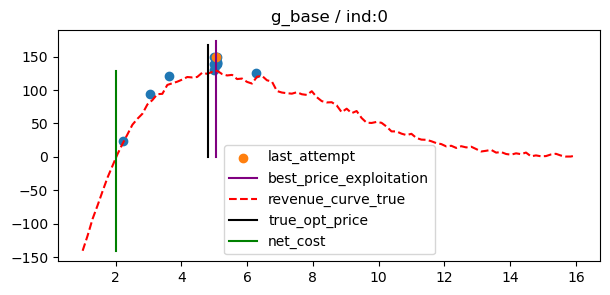

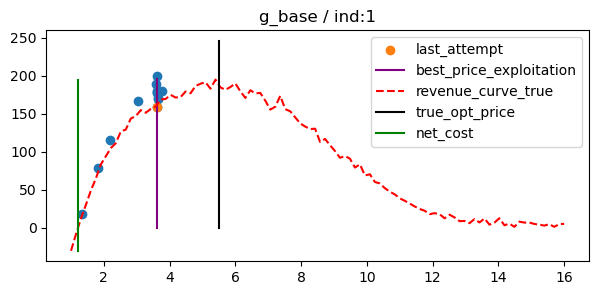

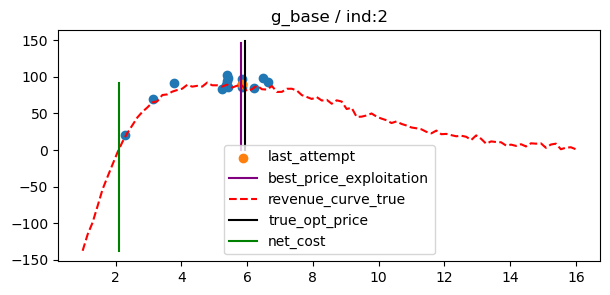

In [1858]:
# нет принудительного исследования
naive = NaiveOptimizer(env, INIT_PRICES,explore=0.0)
naive.train(10)
plot_results_optimizer(naive, 3,OPT_GREEDY)

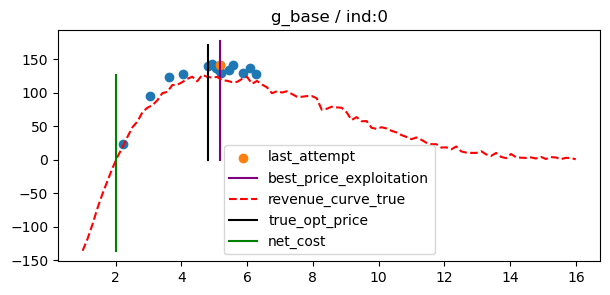

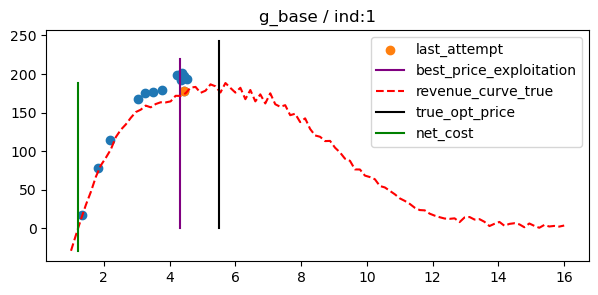

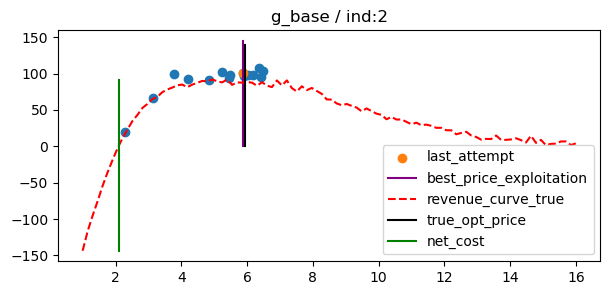

In [1860]:
# есть принудительное исследование
naive = NaiveOptimizer(env, INIT_PRICES,explore=0.3)
naive.train(10)
plot_results_optimizer(naive, 3,OPT_GREEDY)

In [1861]:
class BanditOptimizer(NaiveOptimizer):
    def __init__(self,env,init_prices, every_point, exploration_parameter):
        super().__init__(env,init_prices, every_point)
        self.env = env
        self.alpha = exploration_parameter
        self.net_cost = NET_COST
        self.bias = BIAS_BINS
        self.history = dict(zip(range(self.env.n_goods), [np.array([0.05,] * len(self.bias)) for i in range(self.env.n_goods)]))
        self.history_revenue = np.array([[0,] * len(self.bias)] * self.env.n_goods)
        self.use_bin = np.array([0,]*self.env.n_goods)
        
        
    def step(self,):
        opt_prices = self.get_optimal_prices()
        self.prices_bufer = np.concatenate((self.prices_bufer, opt_prices.reshape(1,-1)))
        revs = self.get_revenue(opt_prices)
        self.history_revenue[np.arange(self.env.n_goods), self.use_bin] = revs
        self.revenue_bufer = np.concatenate((self.revenue_bufer, revs.reshape(1,-1)))
        
        
    def get_optimal_prices(self,):
        opt_prices = np.array(Parallel(n_jobs=N_JOBS)(delayed(self.get_optimal_price_for_good)(i) for i in range(self.env.n_goods)))
        return opt_prices

    def get_optimal_price_for_good(self,i):
        prices = self.prices_bufer.T[i]
        revenue = self.revenue_bufer.T[i]
        
        inds_best_points = np.argsort(-revenue)[:len(revenue) - len(revenue)//10]
        
        
        prices = prices[inds_best_points].reshape(-1,1)
        revenue = revenue[inds_best_points]
        
        x = np.concatenate((prices**2, prices),axis=1)
        lr = LinearRegression()
        lr.fit(x, revenue)
        
        
        flat_bins = (NET_COST[i] + self.bias)
        x_bins = flat_bins.reshape(-1,1)
        x_bins = np.concatenate((x_bins**2, x_bins),axis=1)
        
        y_bins = lr.predict(x_bins)
        
        
        n_dist = self.history[i] 
        explore = self.alpha * np.sqrt(np.log(n_dist.sum()) / n_dist)
        opt_bin = np.argmax(y_bins + explore)
        opt = flat_bins[opt_bin] * float(np.random.uniform(0.95,1.05,1))
        
        self.history[i][opt_bin] += 1
        
        self.use_bin[i] = opt_bin
        
        return opt 
    
    
    def exploit(self,):
        """
        Возвращает оптимальную цену
        """
        revenue_hist = self.history_revenue
        freq = np.stack(list(self.history.values()))
        
        best_bins = np.argmax(revenue_hist / freq, axis=1)
        
        return (NET_COST.reshape(-1,1) + BIAS_BINS.reshape(1,-1))[np.arange(self.env.n_goods), best_bins]
    


In [1862]:
BIAS_BINS = np.concatenate((np.linspace(0.1,1,10),np.linspace(1.2,3,10),np.linspace(3.3,6,10), np.linspace(6.1,8,4)))

### Тестируем алгоритм с разным значением гиперпараметра, отвечающего за исследование.

$$\max_x (E(\hat{y}(x)) + \alpha  \sqrt{\log(n)/n_i})$$
$\alpha$ - параметр, отвечающий за исследование среды. Необходим, поскольку масштаб цен не откалиброван под алгоритм

Wall time: 902 ms


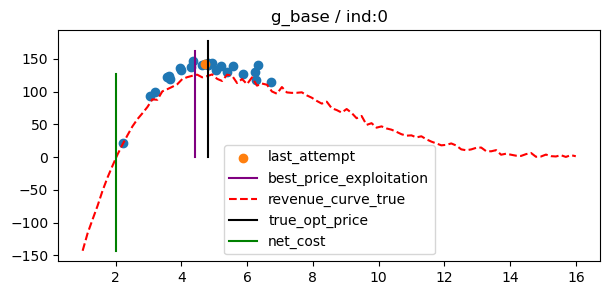

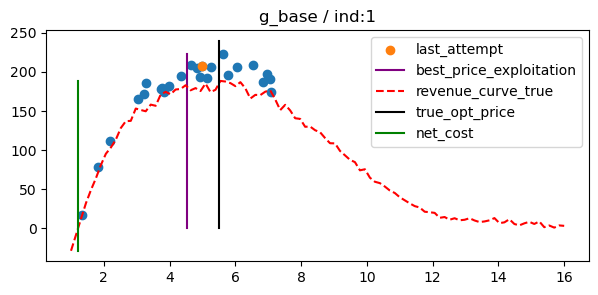

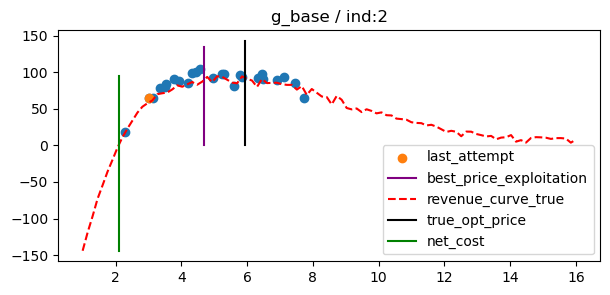

In [1877]:
%%time
bandit = BanditOptimizer(env,init_prices=INIT_PRICES,every_point=0,exploration_parameter=5)
bandit.train(20)
plot_results_optimizer(bandit, 3,OPT_GREEDY)

Wall time: 1.2 s


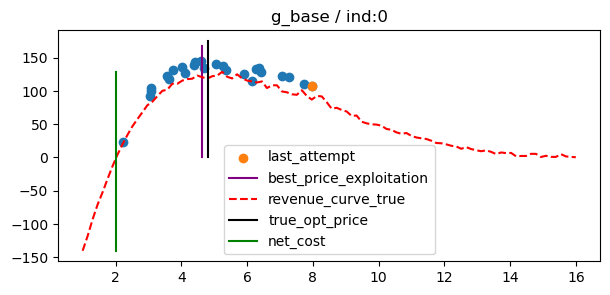

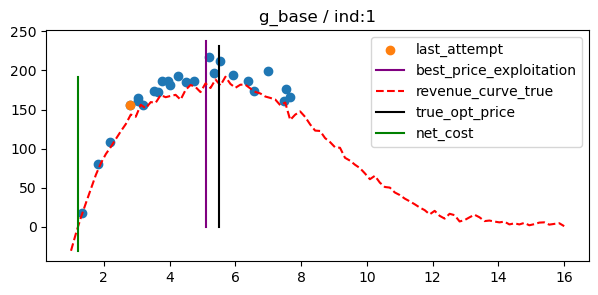

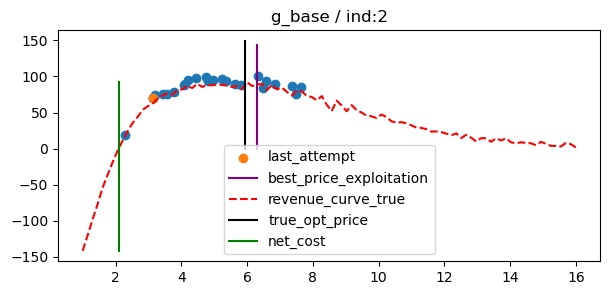

In [1876]:
%%time
# больше исследования приводит к поиску лучшей цены
bandit = BanditOptimizer(env,init_prices=INIT_PRICES,every_point=0,exploration_parameter=10)
bandit.train(20)
plot_results_optimizer(bandit, 3,OPT_GREEDY)

# Поиск оптимальных цен 

## Наивный алгоритм

In [2087]:
def missed_revenue(naive_opt):
    print("Упущенная прибыль равна: ",np.mean([np.mean(naive.get_revenue(OPT_GREEDY) - naive.get_revenue(naive_opt)) for i in range(30)]))

In [2088]:
%%time
naive_history_prices = {}
naive_history_trajectory = {}
naive = NaiveOptimizer(env, INIT_PRICES)
env.reset_shares_types_agents()
for n_it in [10,20,30]:
    naive.train(10)
    naive_history_prices[n_it] = naive.get_optimal_prices()
    naive_history_trajectory[n_it] = naive.trajectory()

Wall time: 865 ms


In [2089]:
### средняя на товар упущенная прибыль!
missed_revenue(naive.exploit())

Упущенная прибыль равна:  23.78828572552619


C:\Users\PC\AppData\Local\Temp\ipykernel_5524\4080648362.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(7,3))


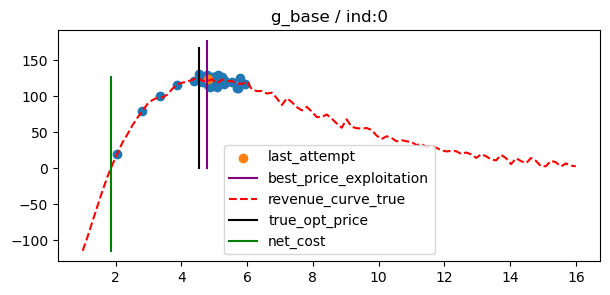

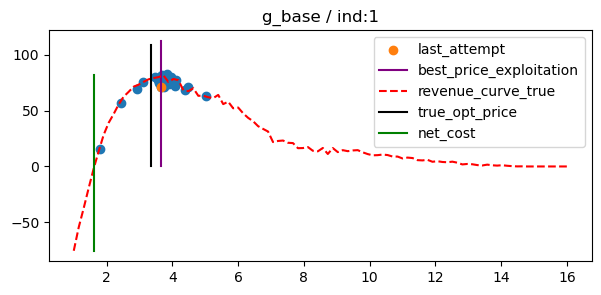

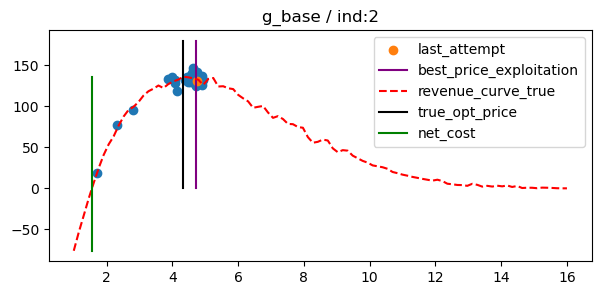

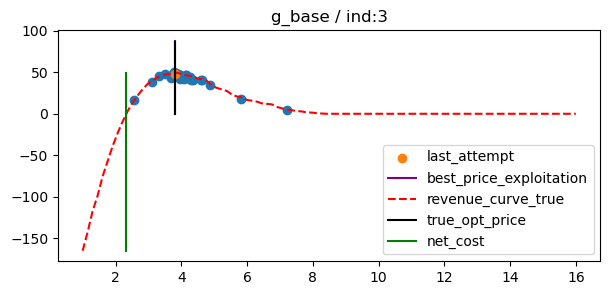

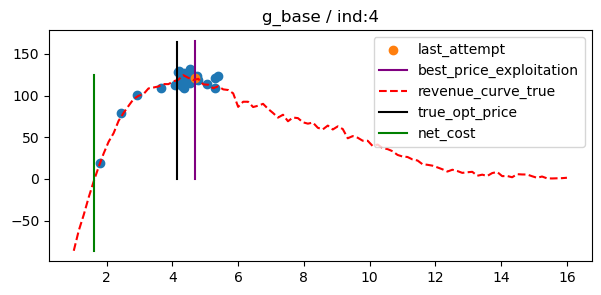

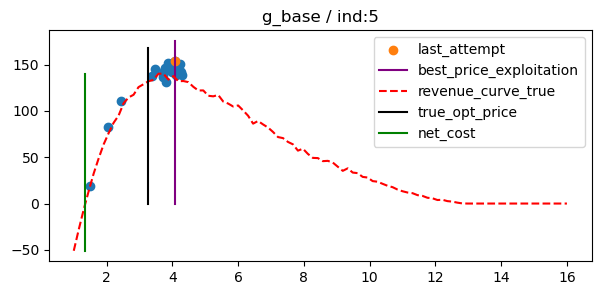

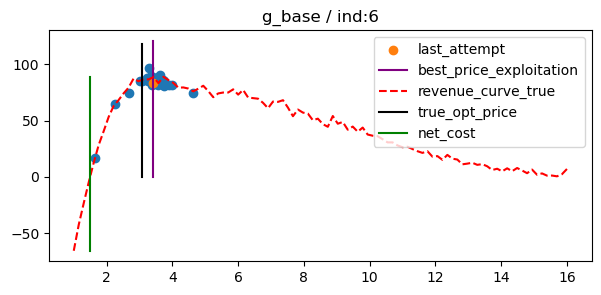

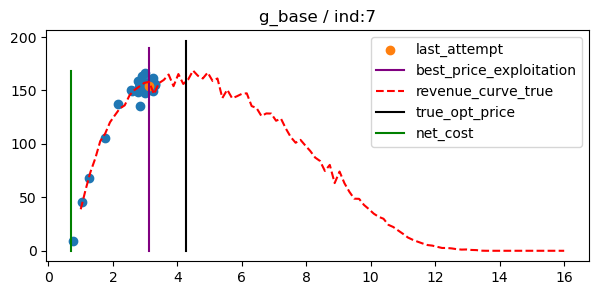

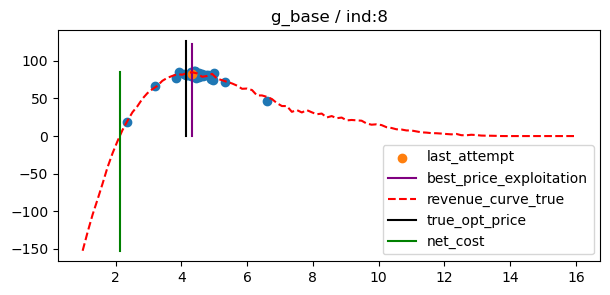

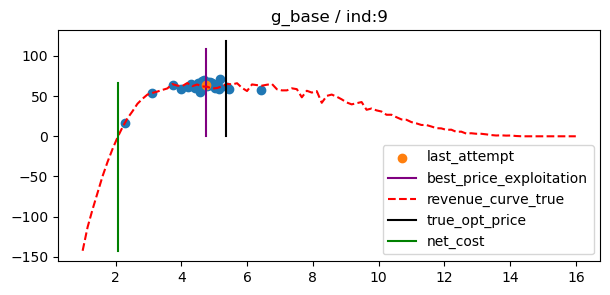

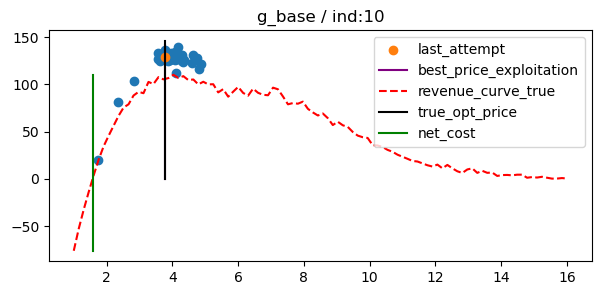

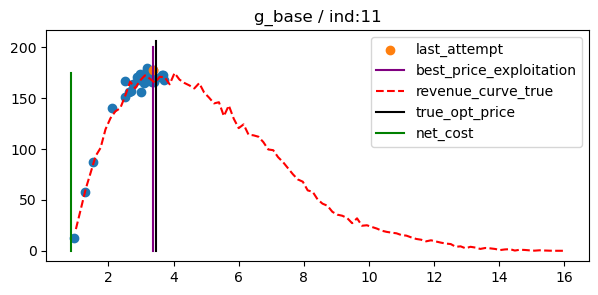

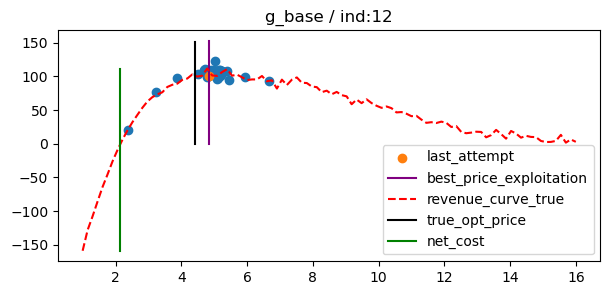

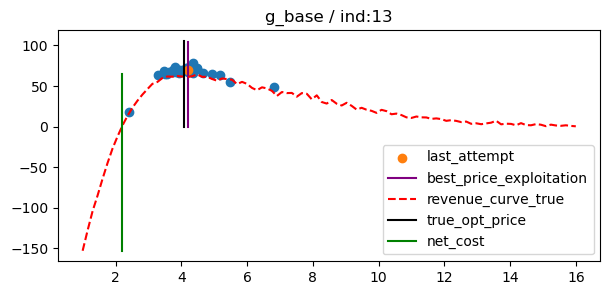

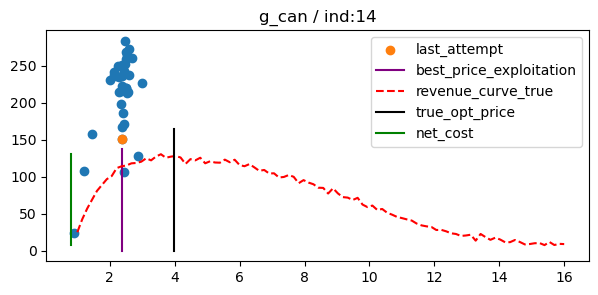

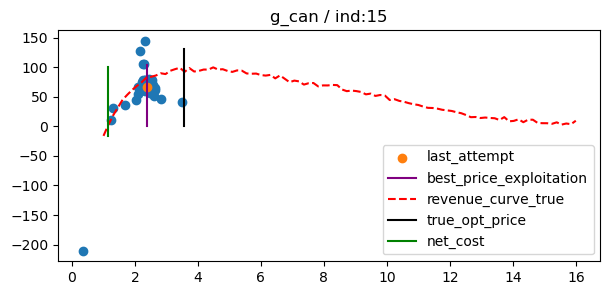

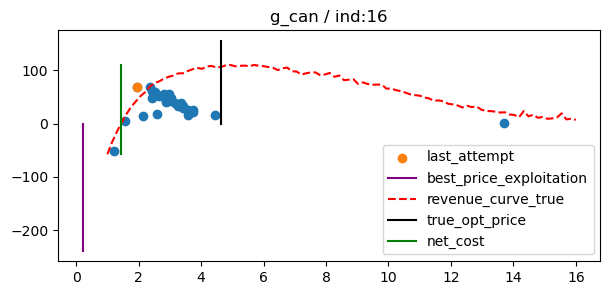

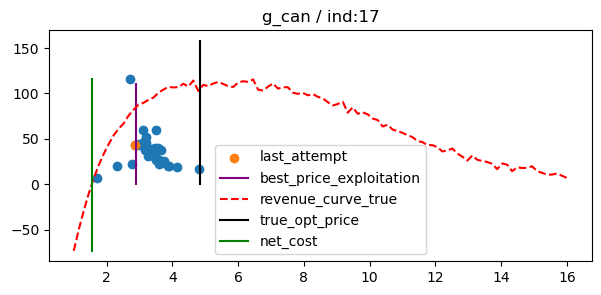

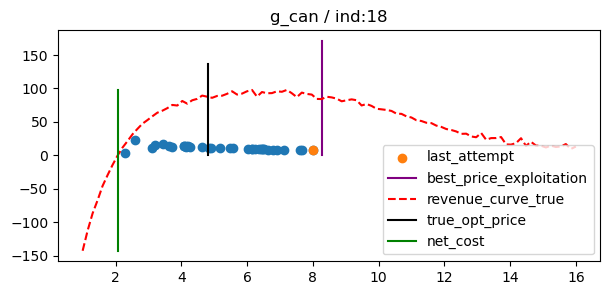

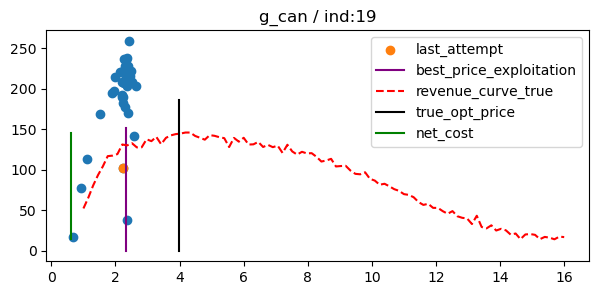

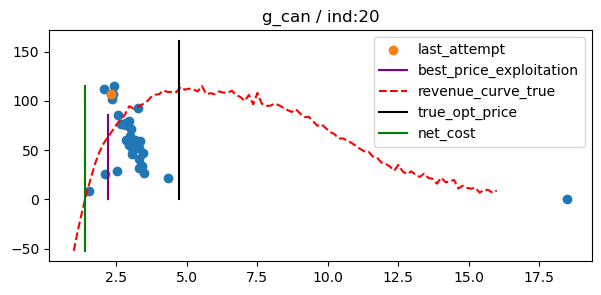

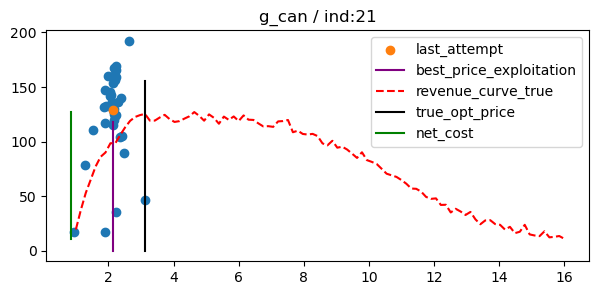

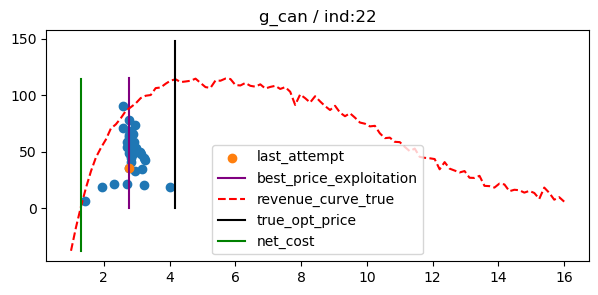

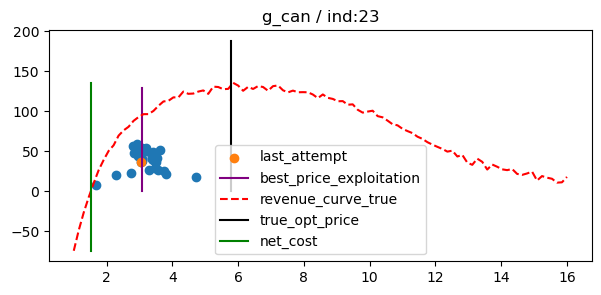

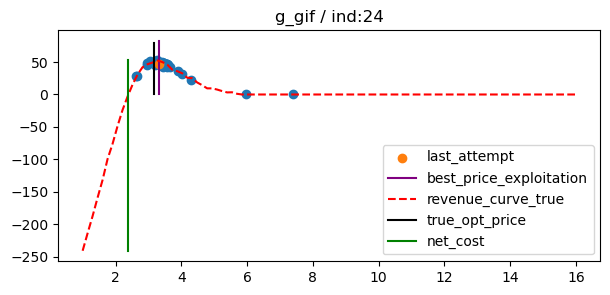

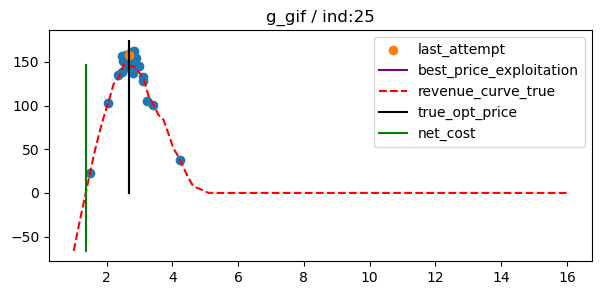

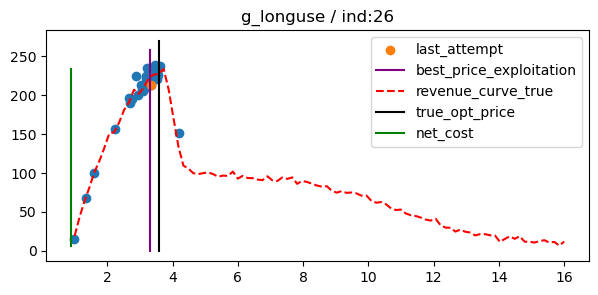

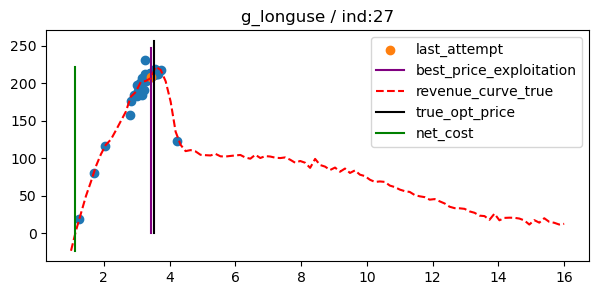

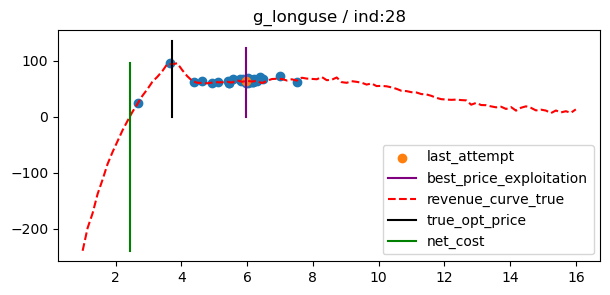

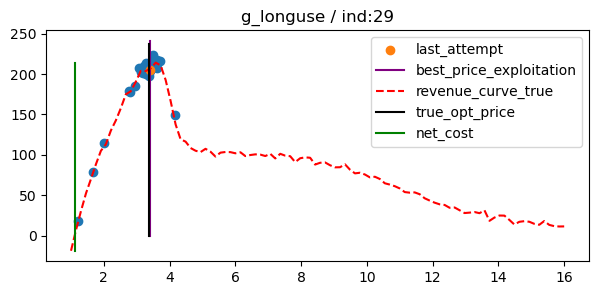

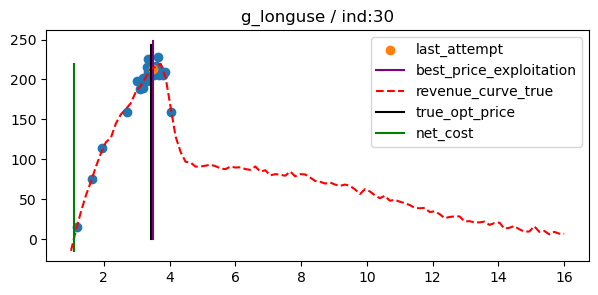

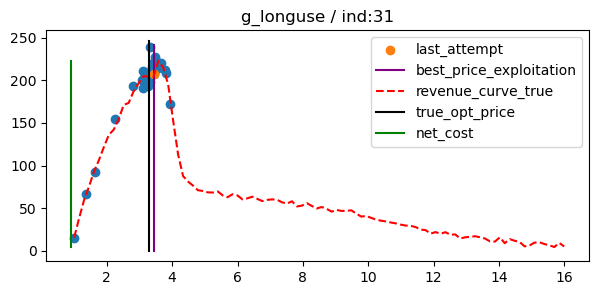

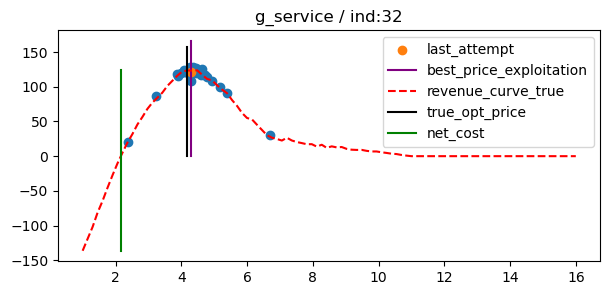

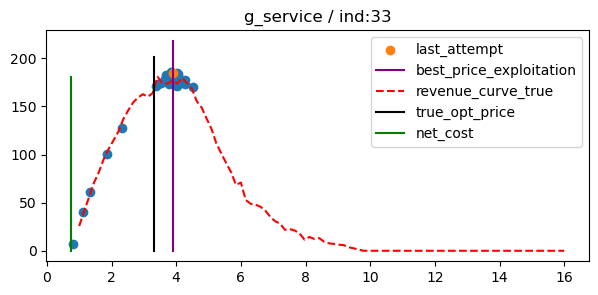

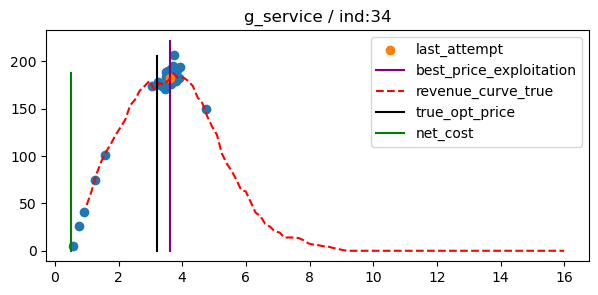

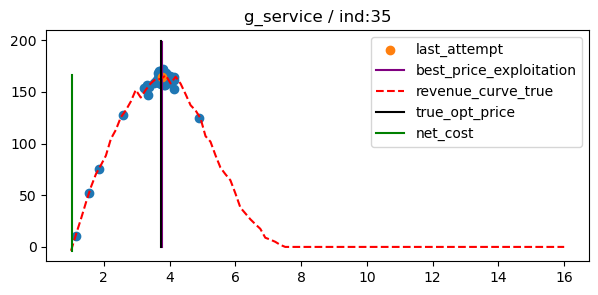

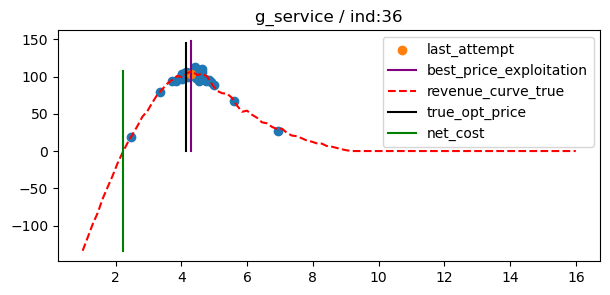

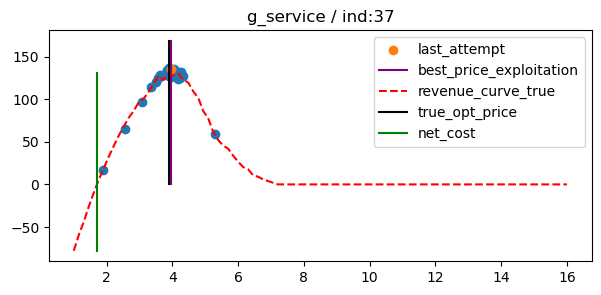

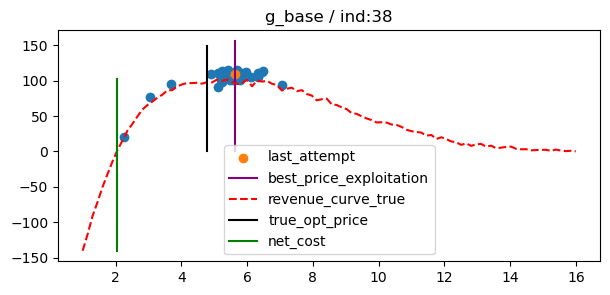

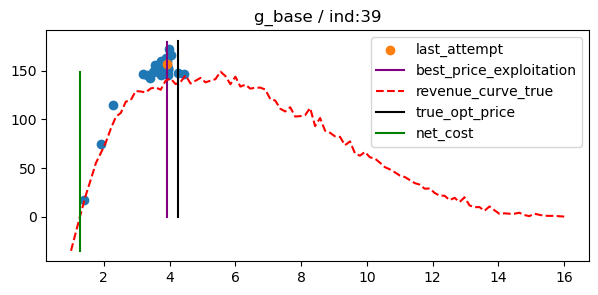

In [2090]:
plot_results_optimizer(naive, 40,OPT_GREEDY)

## Бандитский подход

In [2091]:
%%time
bandit_history_prices = {}
bandit_history_trajectory = {}
bandit = BanditOptimizer(env,init_prices=INIT_PRICES,every_point=0,exploration_parameter=2)
for n_it in [10,20,30]:
    bandit.train(10)
    bandit_history_prices[n_it] = bandit.get_optimal_prices()
    bandit_history_trajectory[n_it] = bandit.trajectory()

Wall time: 935 ms


In [2092]:
### средняя на товар упущенная прибыль!

missed_revenue(bandit.exploit())

Упущенная прибыль равна:  12.959095190620651


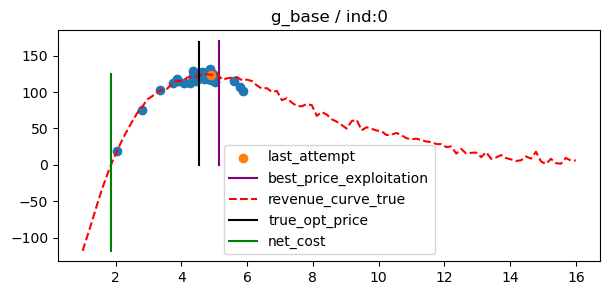

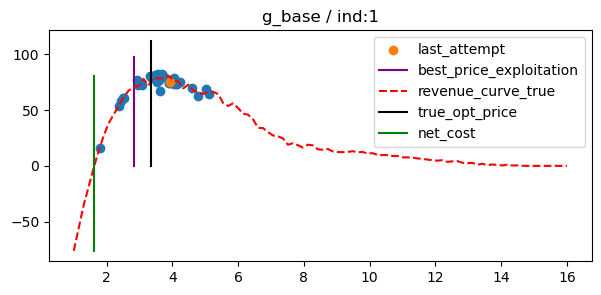

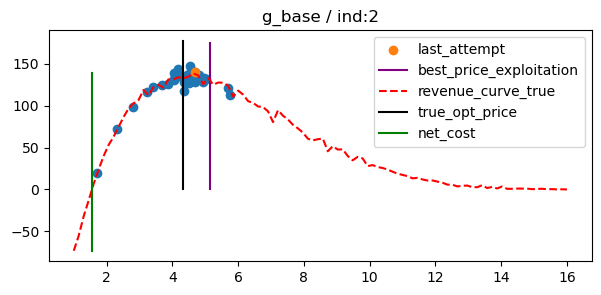

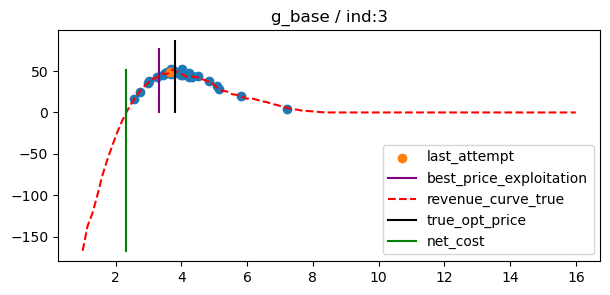

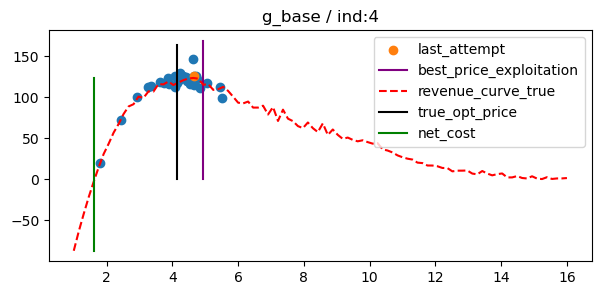

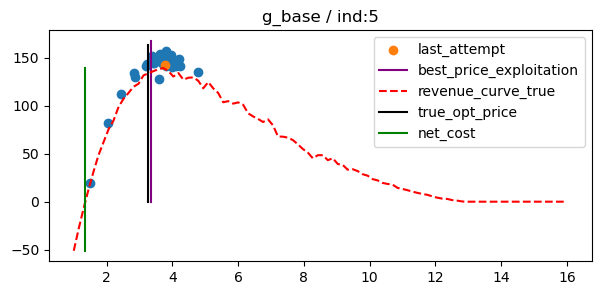

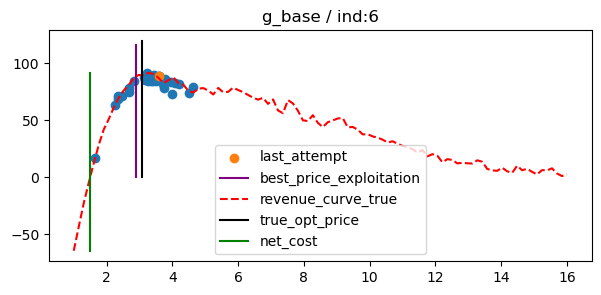

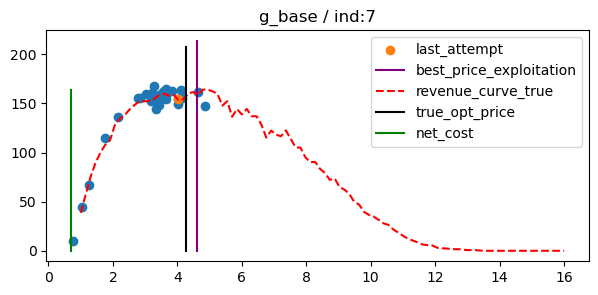

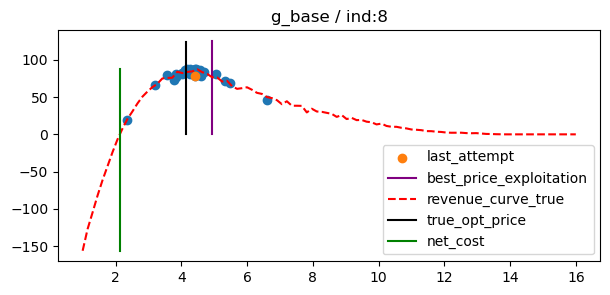

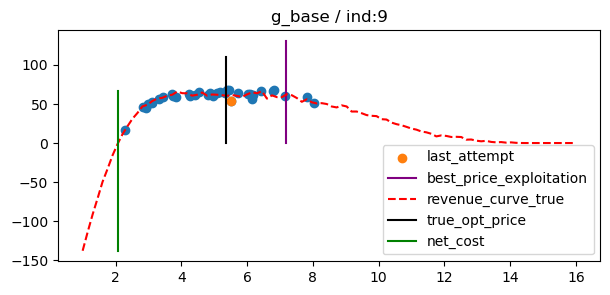

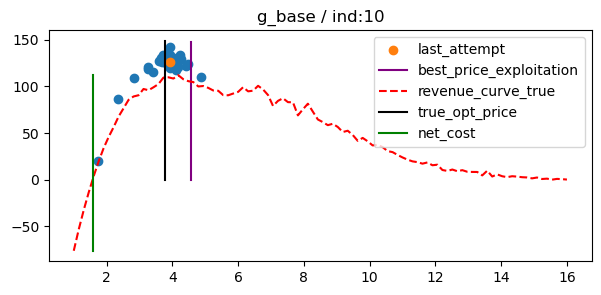

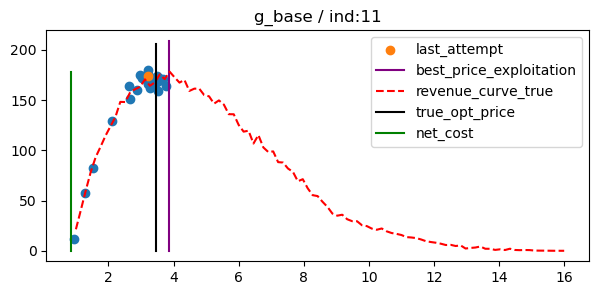

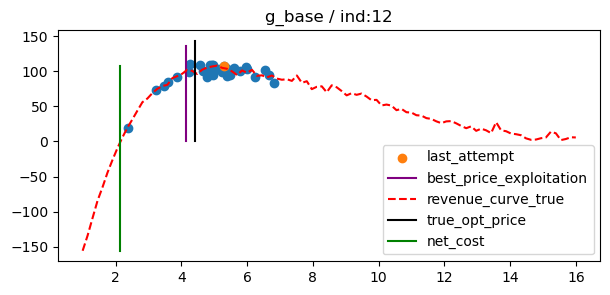

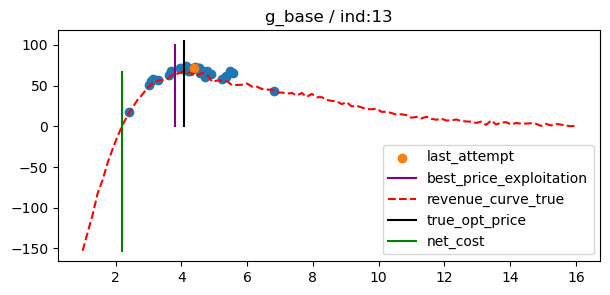

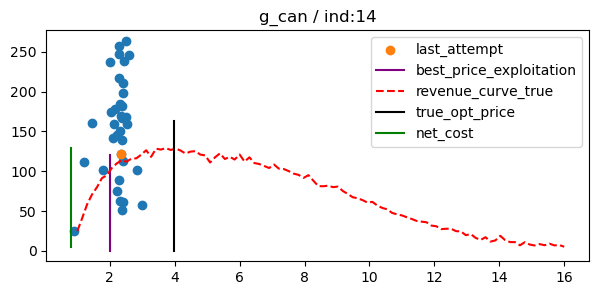

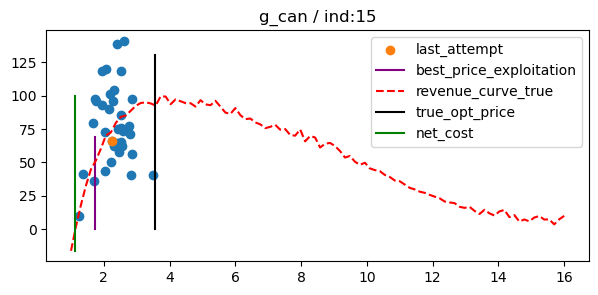

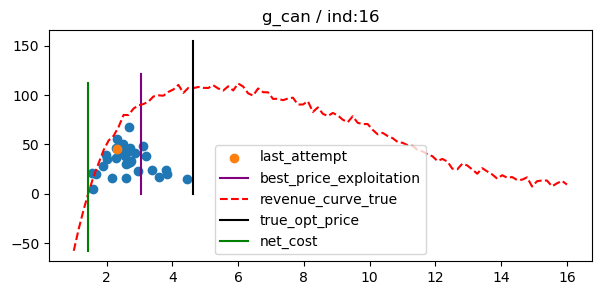

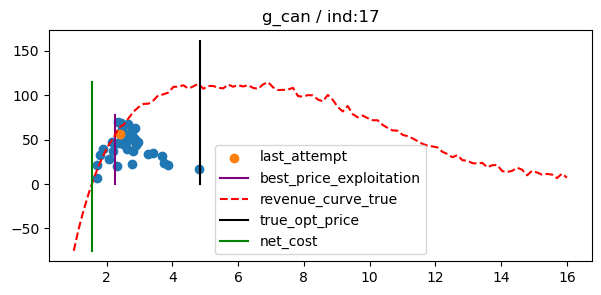

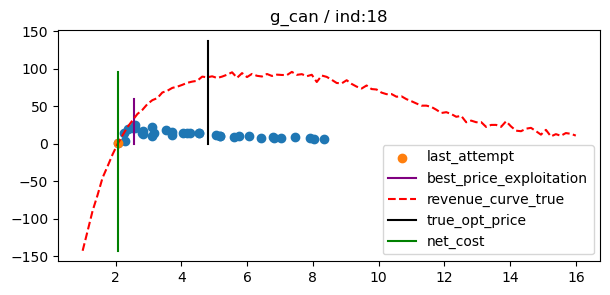

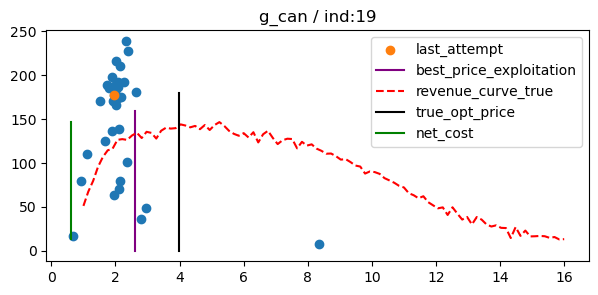

In [2093]:
plot_results_optimizer(bandit, 20,OPT_GREEDY)

#### Сравнение траекторий

In [2094]:
print("Траектория BanditOptimizer хуже на ",round((1 - bandit.trajectory().sum() / naive.trajectory().sum())*100,2),"%")

Траектория BanditOptimizer хуже на  2.01 %


## Выводы:
1. Бандиты лучше нашли оптимум
2. Наивный собрал больше денег за траекторию



# Поиск оптимальных цен при изменяющемся соотношении типов агентов

Каждую итерацию каждый тип агентов меняется в числе на -+5%


В начале у каждого агента коэффициент изменения начального соотношения равен 1. На каждой эпохе доля каждого агента изменяется на -+5%. В конце выводится значения коэффициентов после n итераций.

In [1948]:
# Пример флуктуации долей агентов
env.reset_shares_types_agents()
env.fluctuate_share_types_agents(1)
env.current_shares_types_agents

{'star': 0.9446043798718512,
 'collector': 0.9861135996083439,
 'independent': 1.0624145007833727,
 'base': 0.9679138852288282,
 'poor': 1.0103632444970396}

###  30 итераций. По вырученной прибыли побеждает Наивный

In [2096]:
%%time

naive_history_prices = {}
naive_history_trajectory = {}
bandit_history_prices = {}
bandit_history_trajectory = {}


naive = NaiveOptimizer(env, INIT_PRICES)
bandit = BanditOptimizer(env,init_prices=INIT_PRICES,every_point=0,exploration_parameter=2)

env.reset_shares_types_agents()
for n_it in [10,20,30]:
    for i in range(10):
        env.fluctuate_share_types_agents(n_it - 10 + i)
        naive.train(1)
        bandit.train(1)
        
    naive_history_prices[n_it] = naive.get_optimal_prices()
    naive_history_trajectory[n_it] = naive.trajectory()
    bandit_history_prices[n_it] = bandit.get_optimal_prices()
    bandit_history_trajectory[n_it] = bandit.trajectory()
    
print("last_shares_types_agents for env")
env.current_shares_types_agents

last_shares_types_agents for env
Wall time: 1.81 s


{'star': 1.5857230858388855,
 'collector': 1.24338342377555,
 'independent': 1.0943986992160588,
 'base': 1.1066225478998364,
 'poor': 1.0017853848511833}

C:\Users\PC\AppData\Local\Temp\ipykernel_5524\4080648362.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(7,3))


IndexError: index 40 is out of bounds for axis 0 with size 40

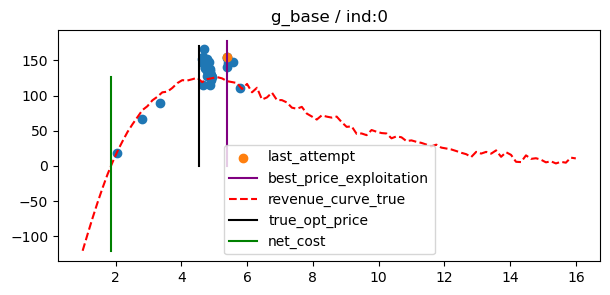

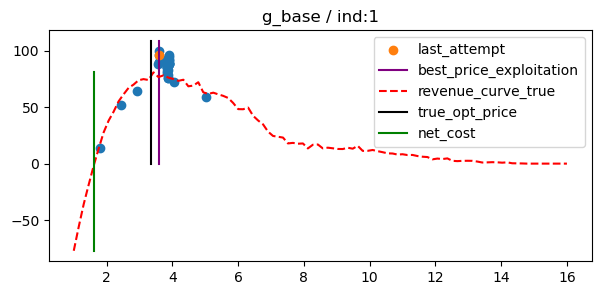

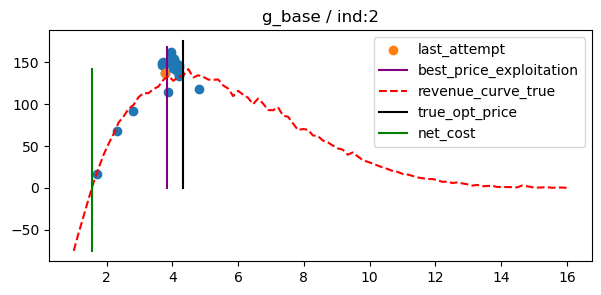

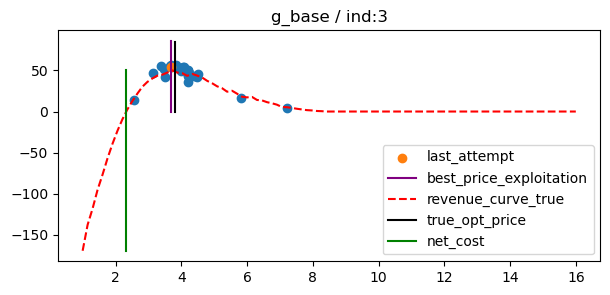

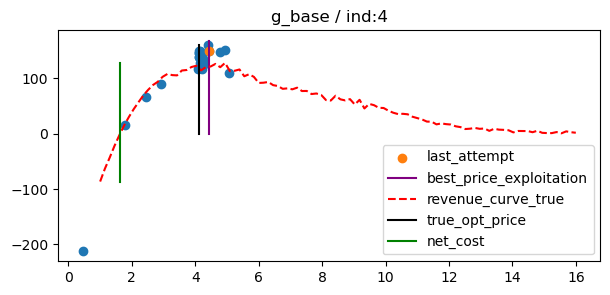

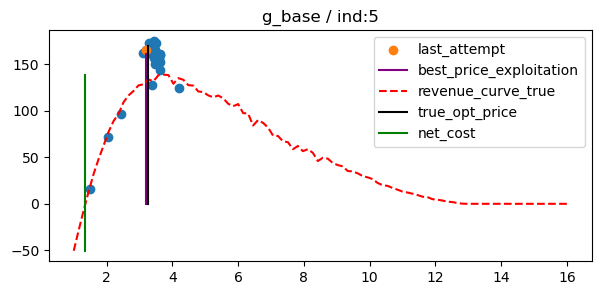

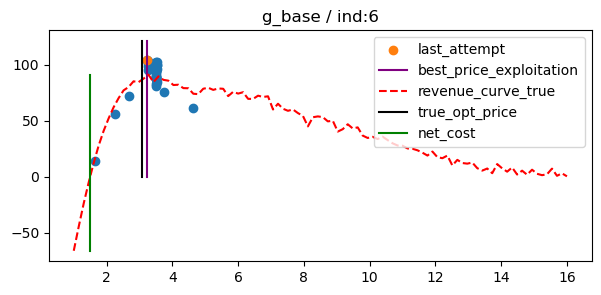

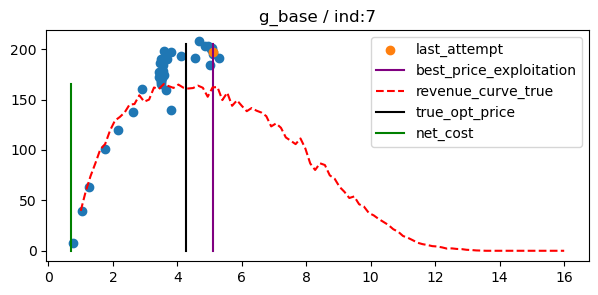

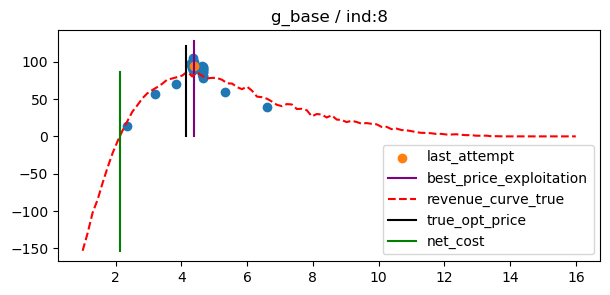

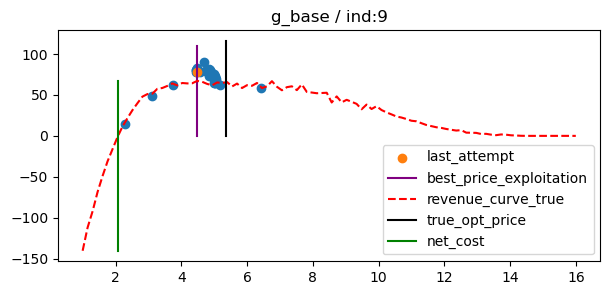

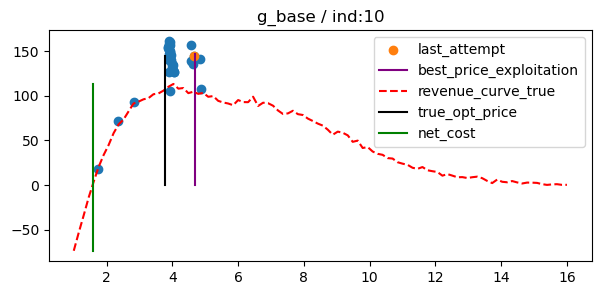

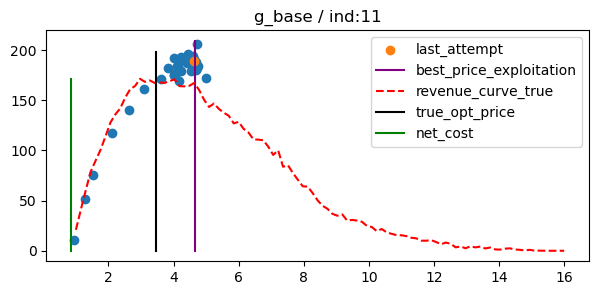

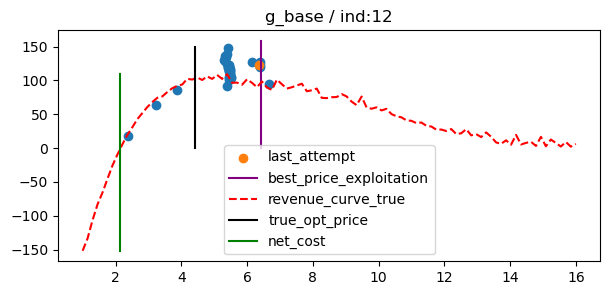

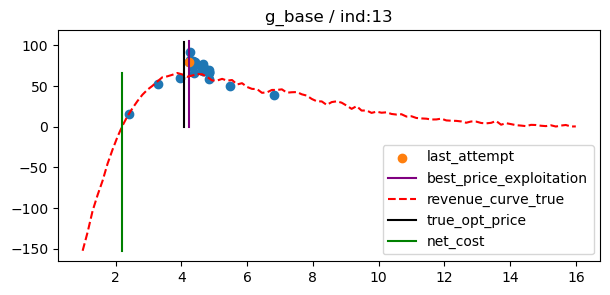

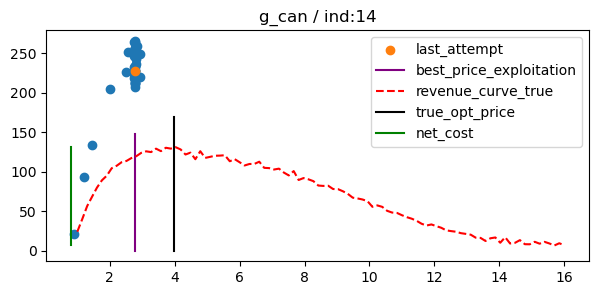

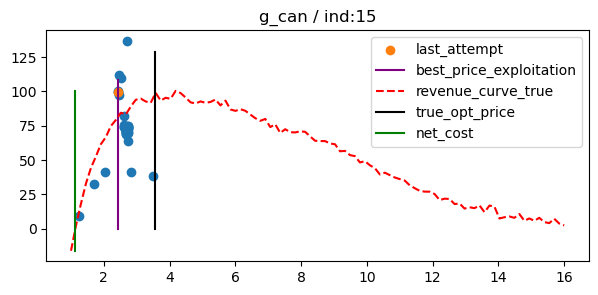

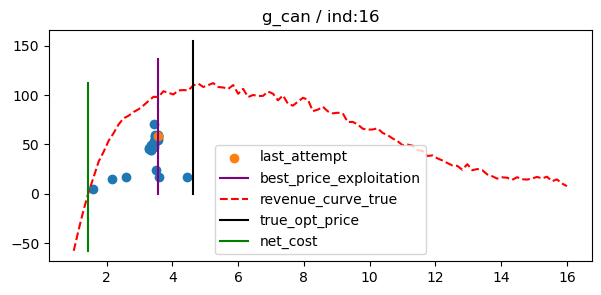

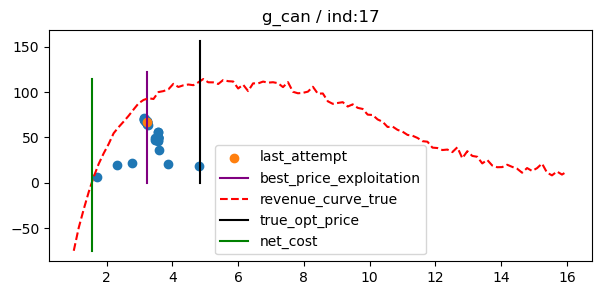

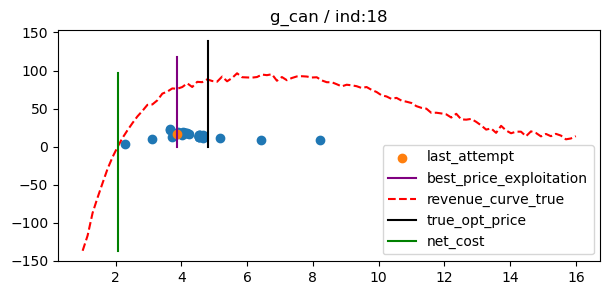

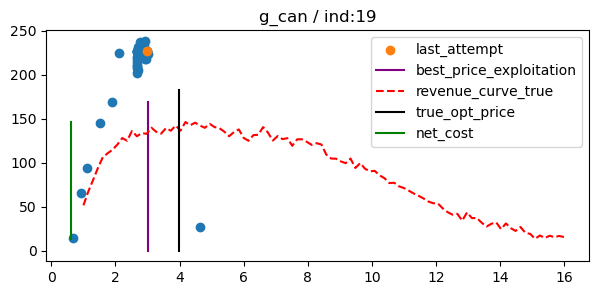

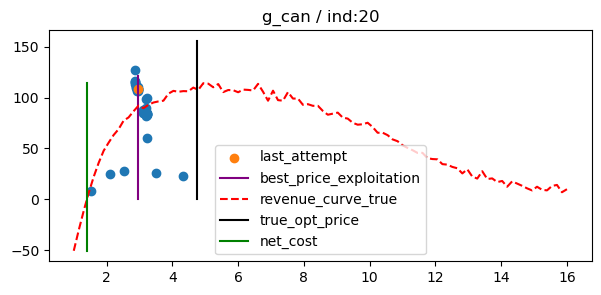

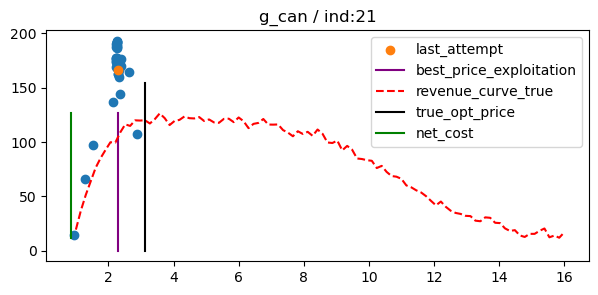

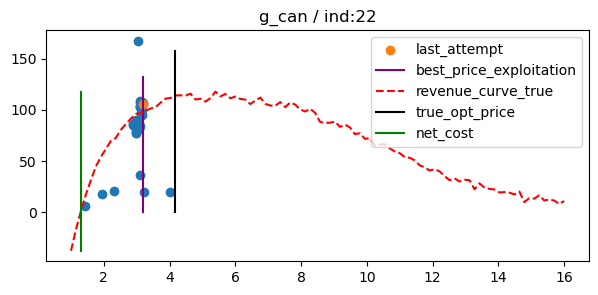

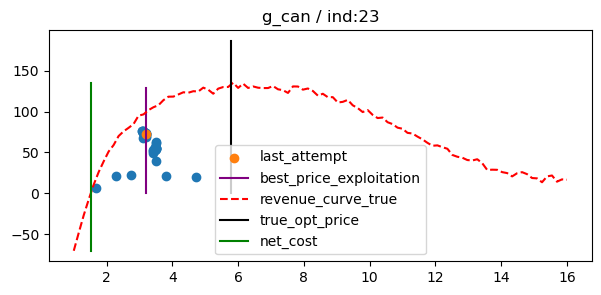

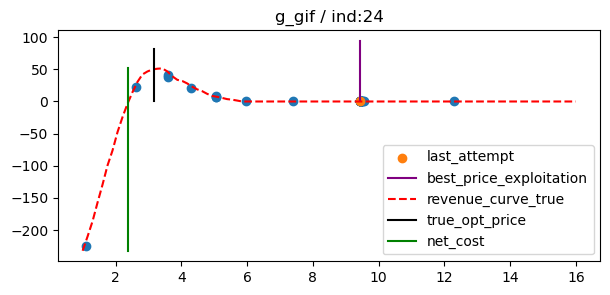

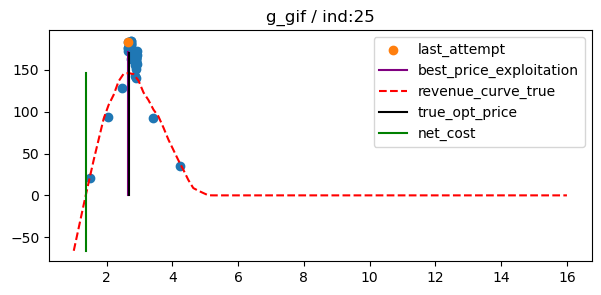

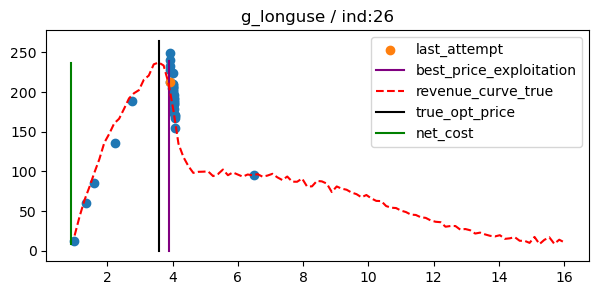

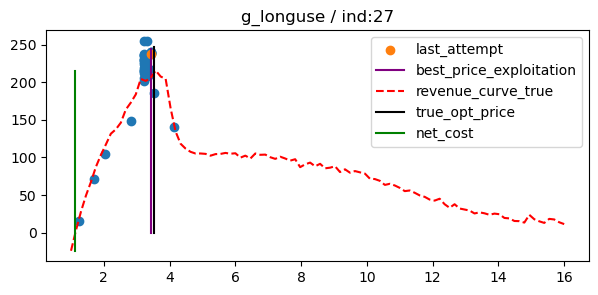

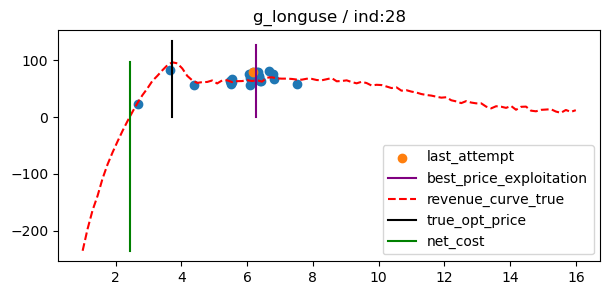

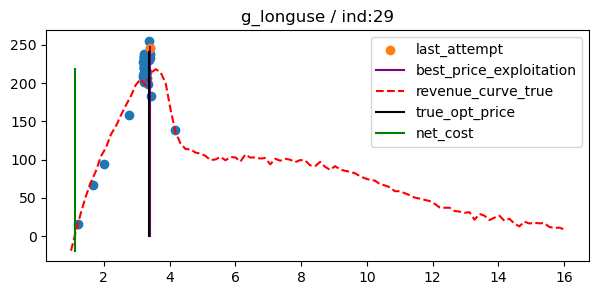

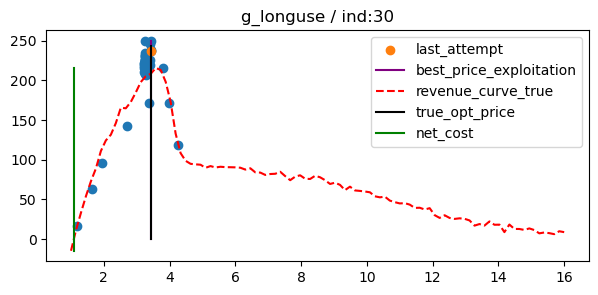

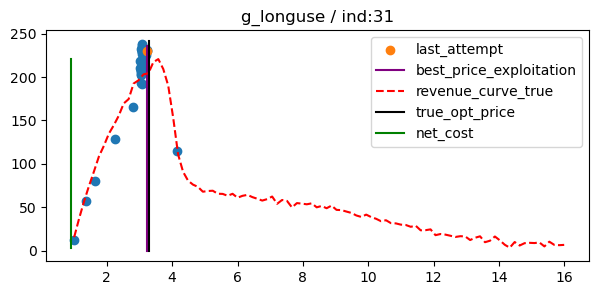

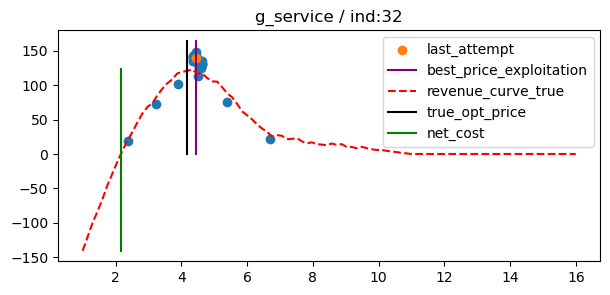

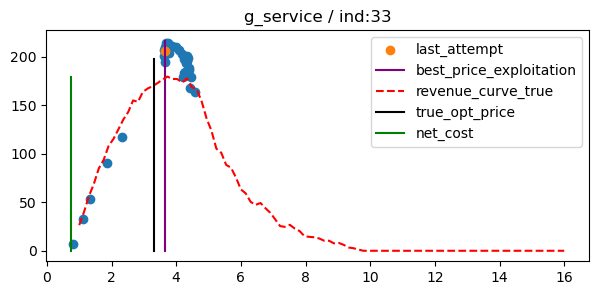

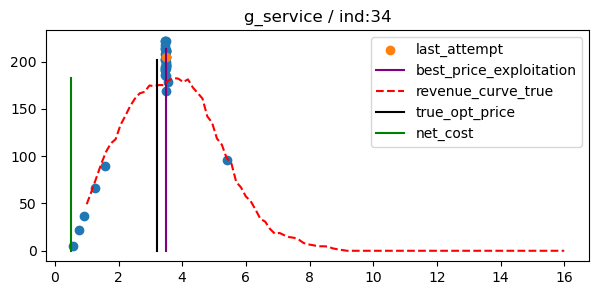

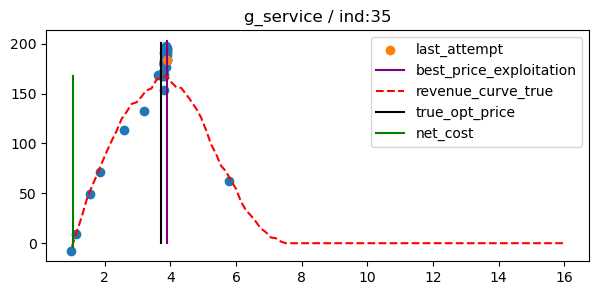

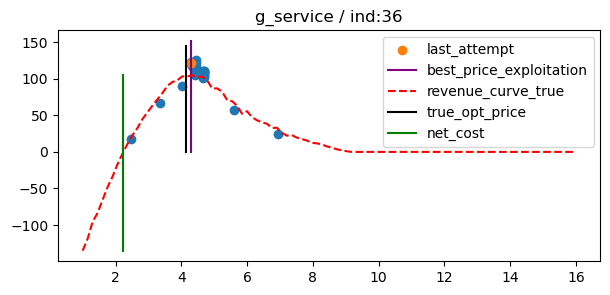

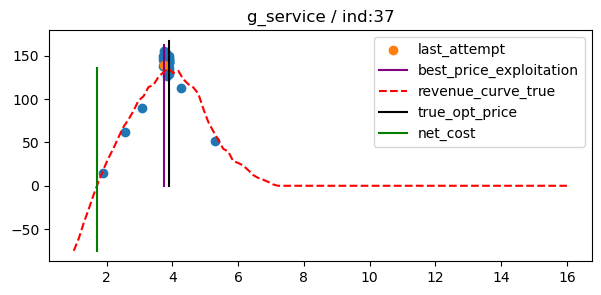

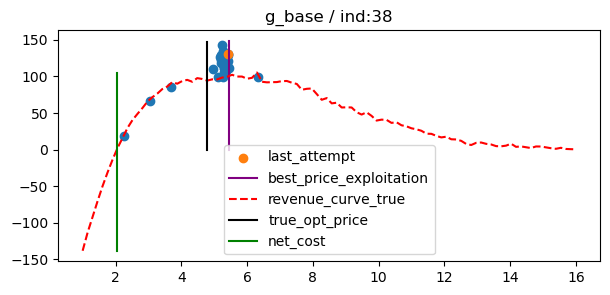

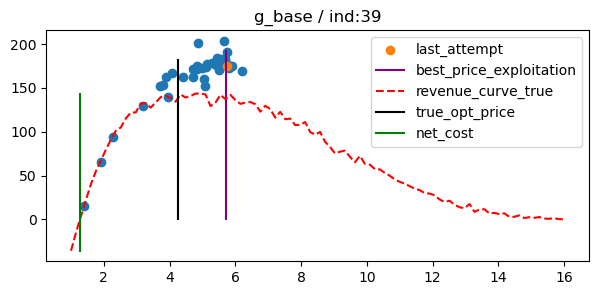

<Figure size 700x300 with 0 Axes>

In [2098]:
plot_results_optimizer(naive, 50,OPT_GREEDY)

C:\Users\PC\AppData\Local\Temp\ipykernel_5524\4080648362.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(7,3))


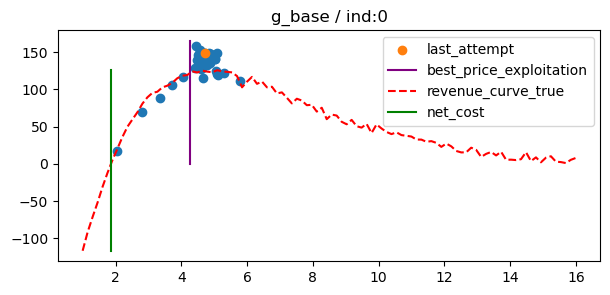

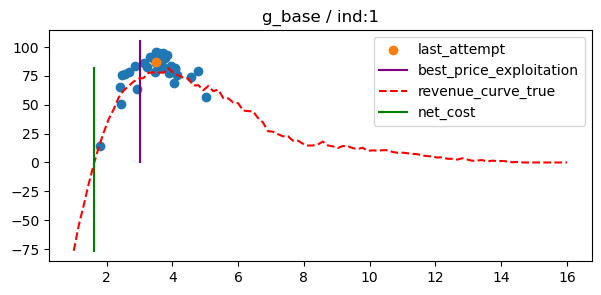

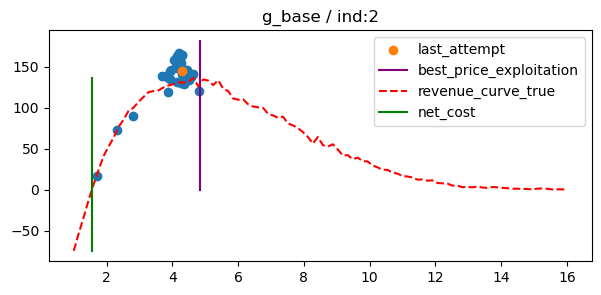

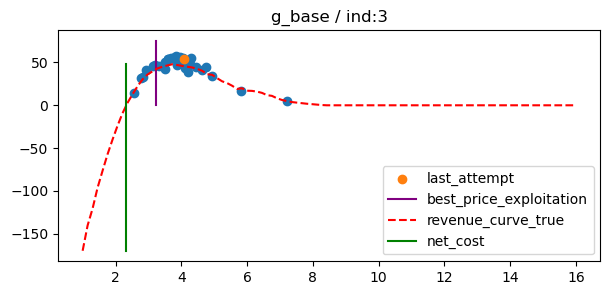

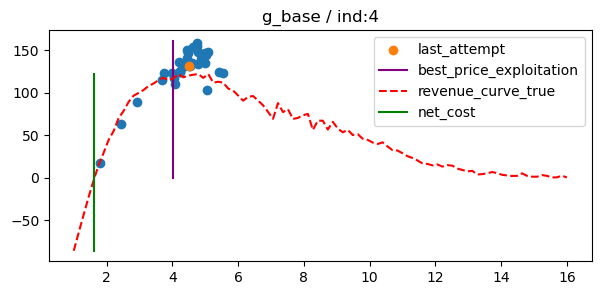

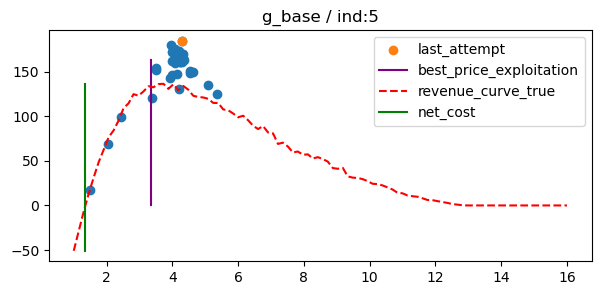

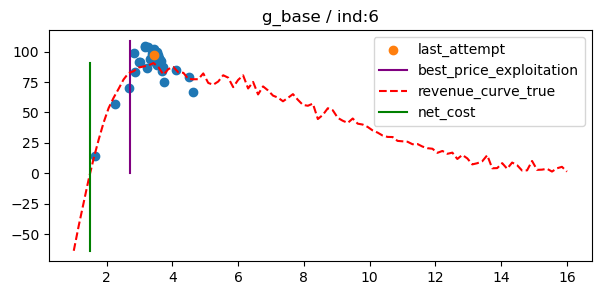

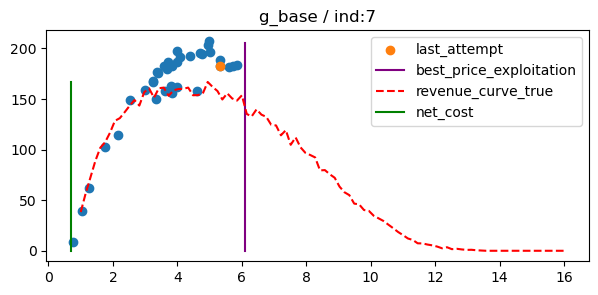

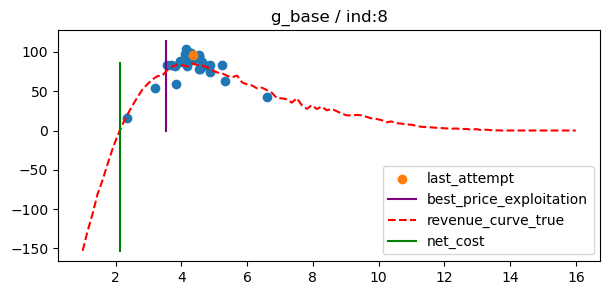

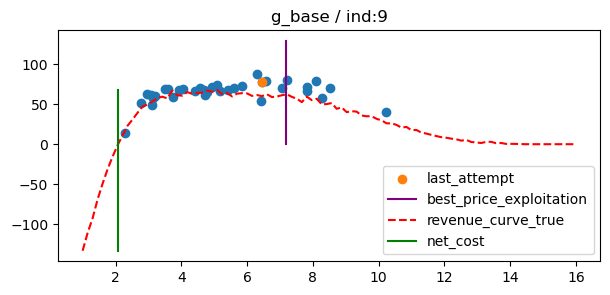

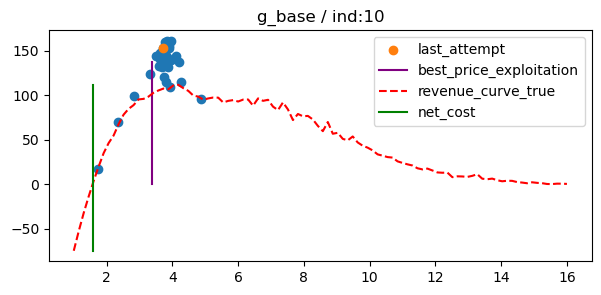

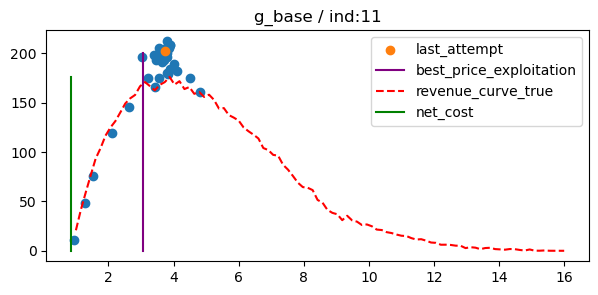

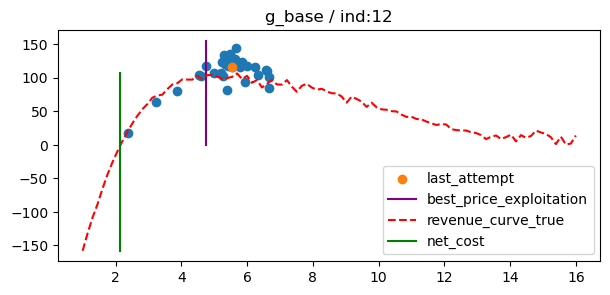

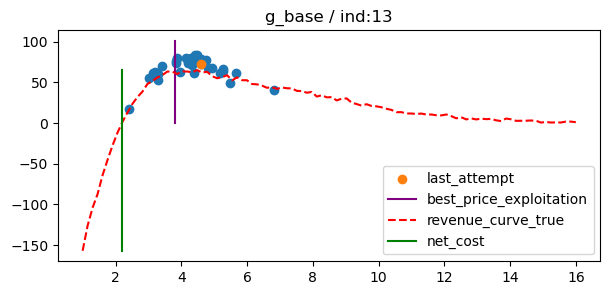

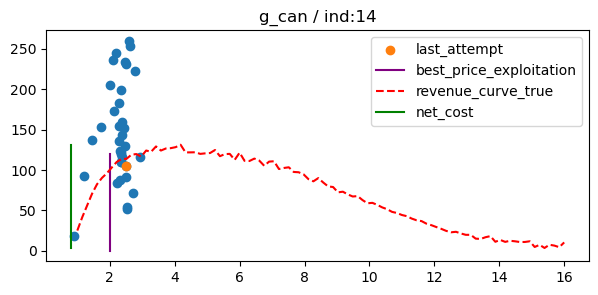

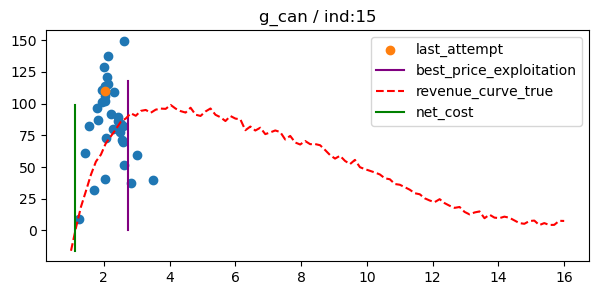

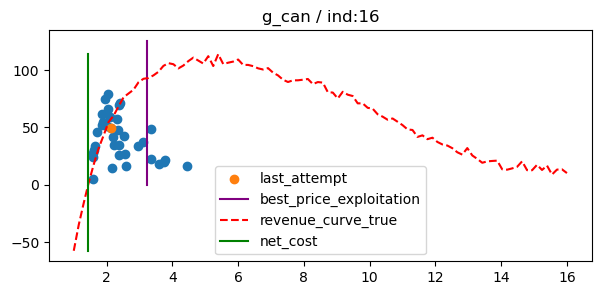

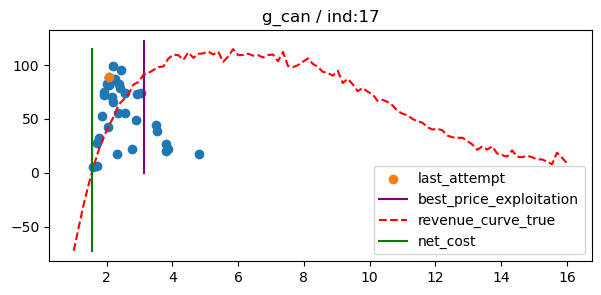

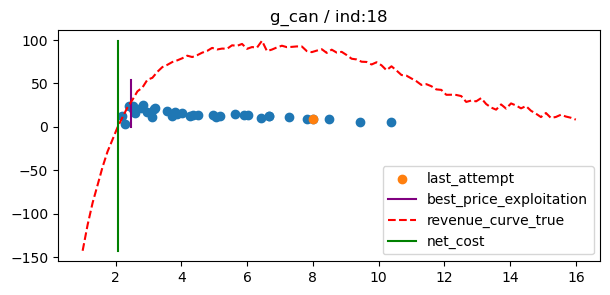

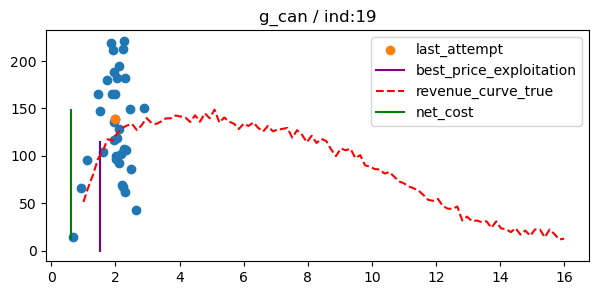

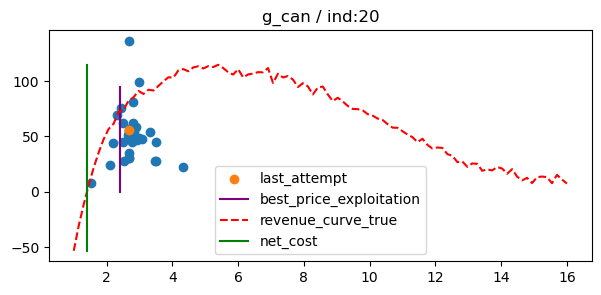

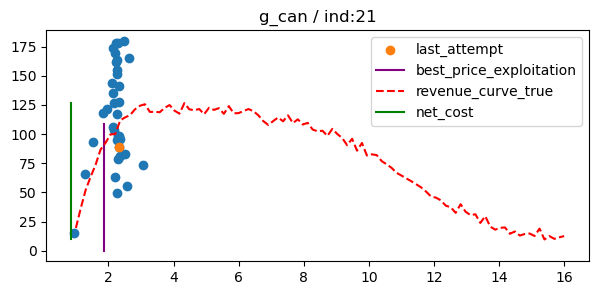

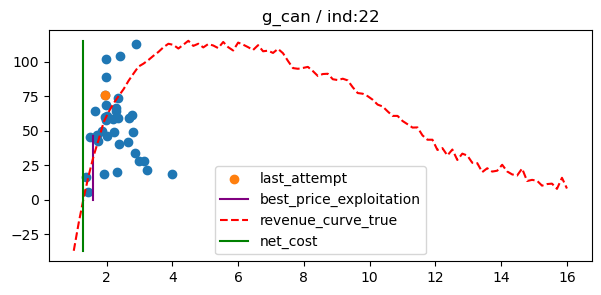

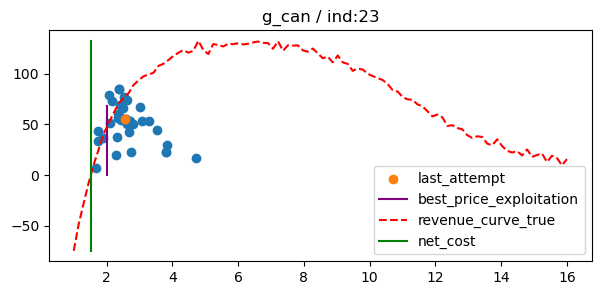

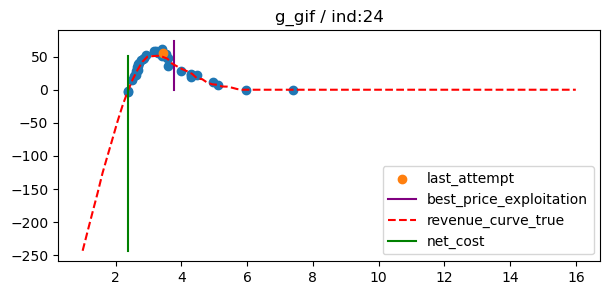

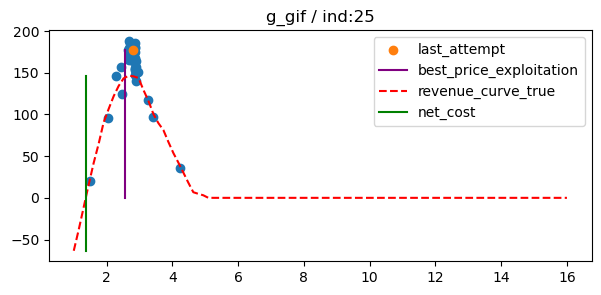

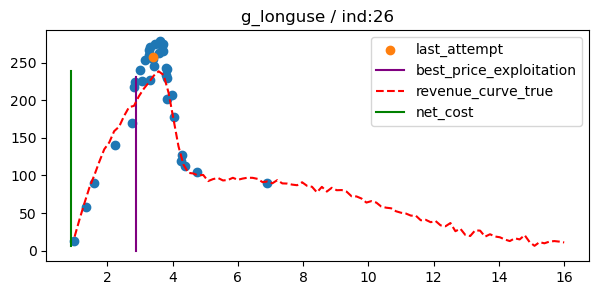

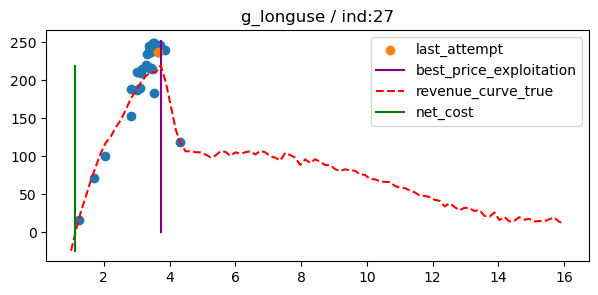

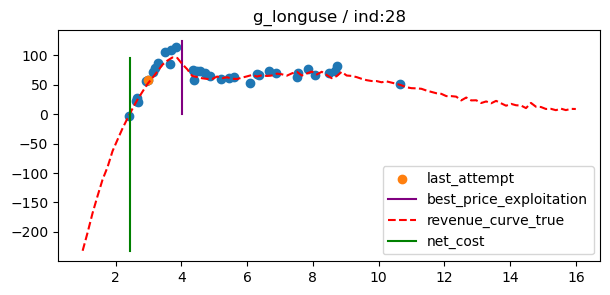

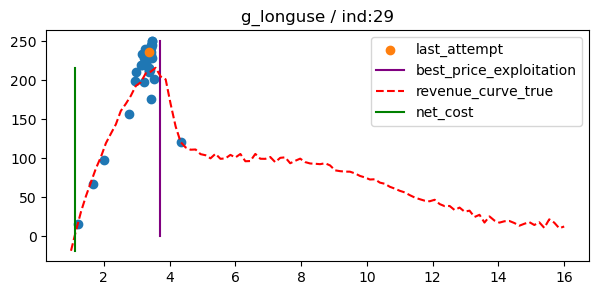

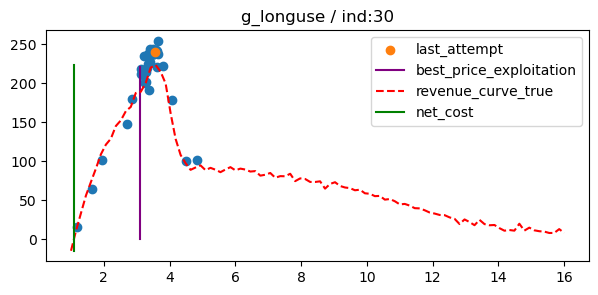

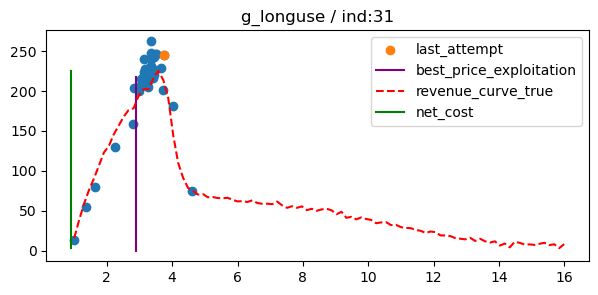

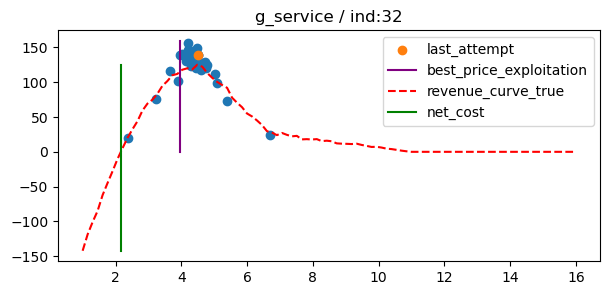

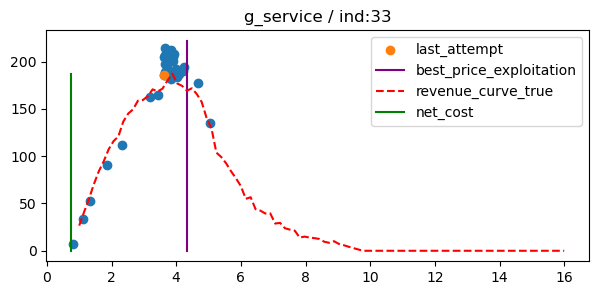

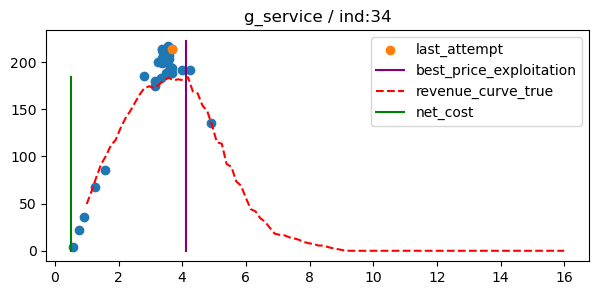

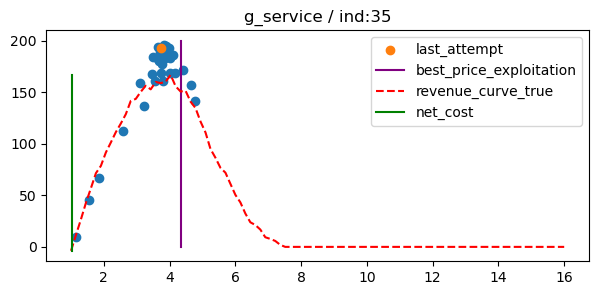

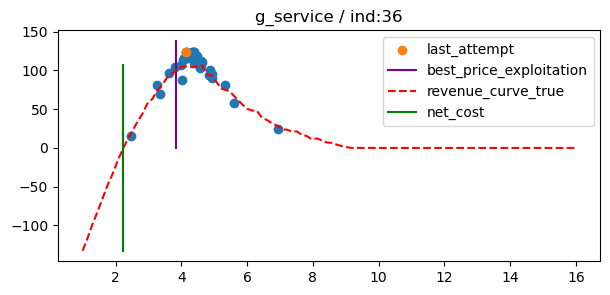

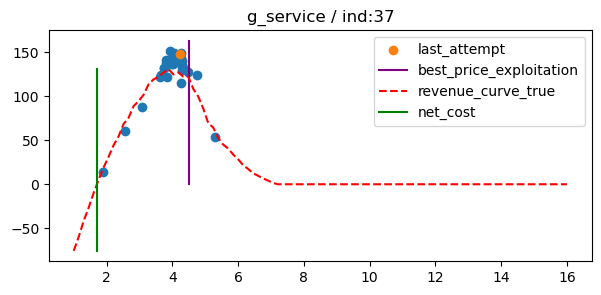

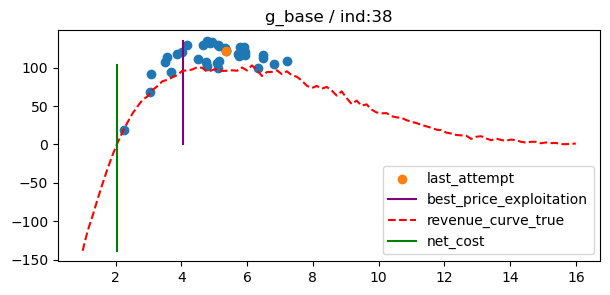

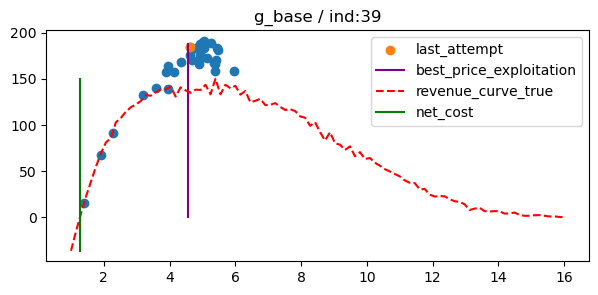

In [2100]:
plot_results_optimizer(bandit, 40,)

In [2101]:
print("Траектория BanditOptimizer хуже на ",round((1 - bandit.trajectory().sum() / naive.trajectory().sum())*100,2),"%")

Траектория BanditOptimizer хуже на  4.39 %


### Выводы 
1. Наивный собрал на 4.39% больше денег

### Протестируем на 80 итерациях

In [2102]:
%%time

naive_history_prices = {}
naive_history_trajectory = {}
bandit_history_prices = {}
bandit_history_trajectory = {}


naive = NaiveOptimizer(env, INIT_PRICES)
bandit = BanditOptimizer(env,init_prices=INIT_PRICES,every_point=0,exploration_parameter=2)

env.reset_shares_types_agents()
for n_it in [10,20,30,40,50,60,70,80]:
    for i in range(10):
        env.fluctuate_share_types_agents(n_it - 10 + i)
        naive.train(1)
        bandit.train(1)
        
    naive_history_prices[n_it] = naive.get_optimal_prices()
    naive_history_trajectory[n_it] = naive.trajectory()
    bandit_history_prices[n_it] = bandit.get_optimal_prices()
    bandit_history_trajectory[n_it] = bandit.trajectory()
    
print("last_shares_types_agents for env")
env.current_shares_types_agents

last_shares_types_agents for env
Wall time: 4.7 s


{'star': 1.1859080573447993,
 'collector': 1.245498225213399,
 'independent': 1.127578128371503,
 'base': 1.148089927017414,
 'poor': 1.0404128260156253}

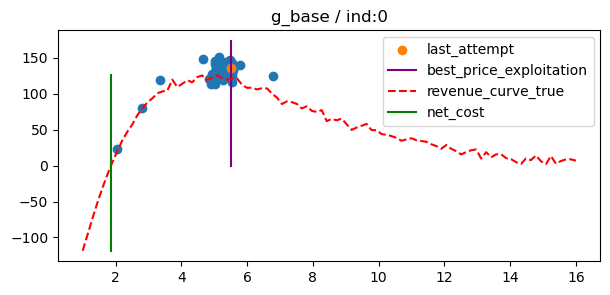

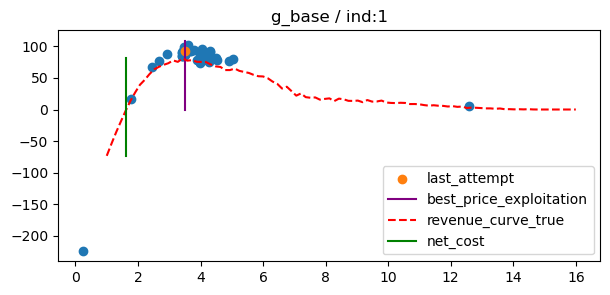

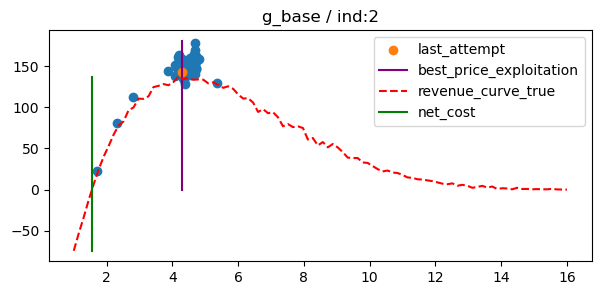

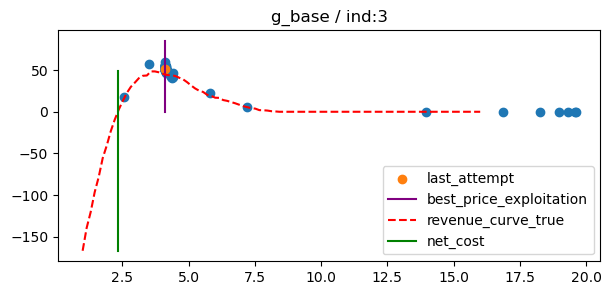

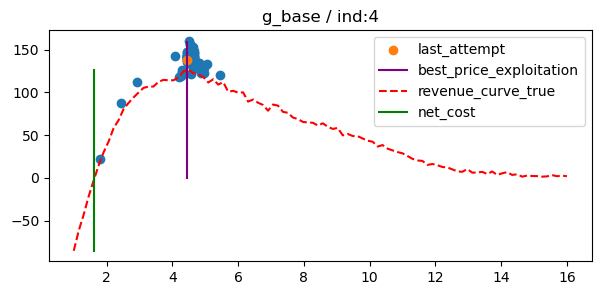

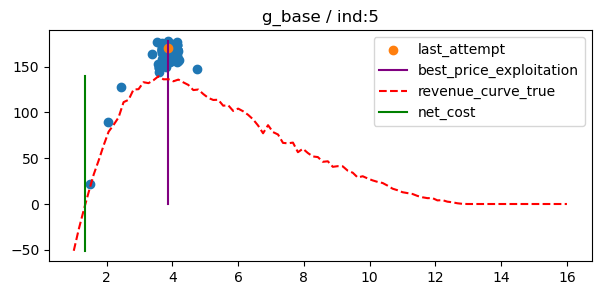

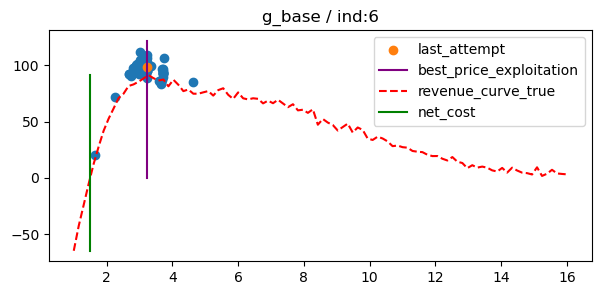

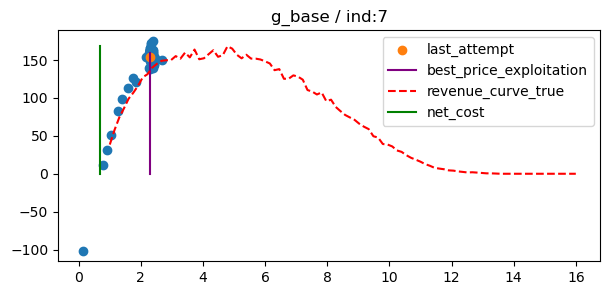

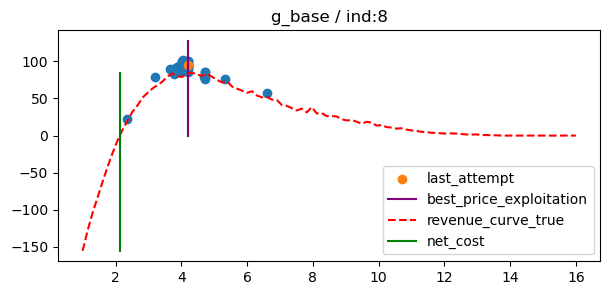

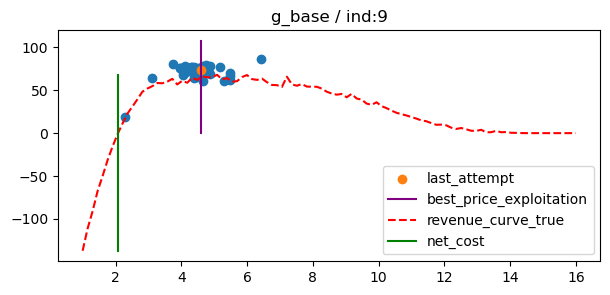

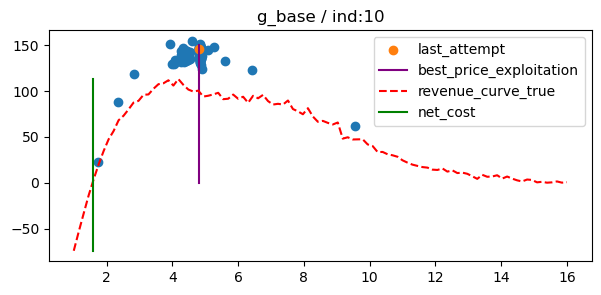

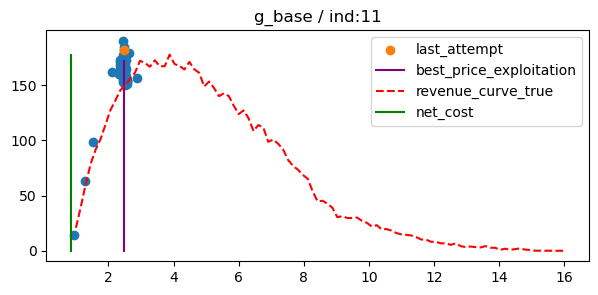

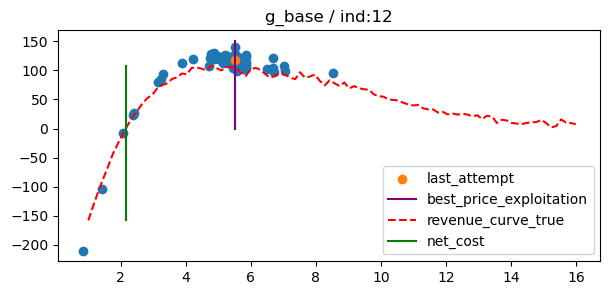

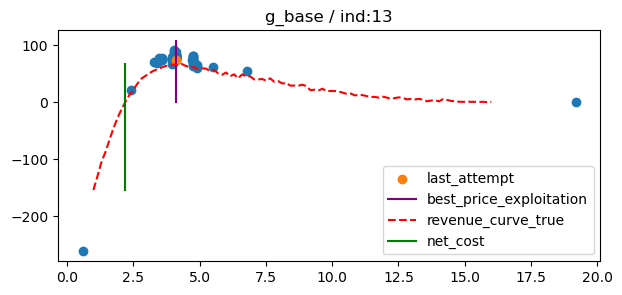

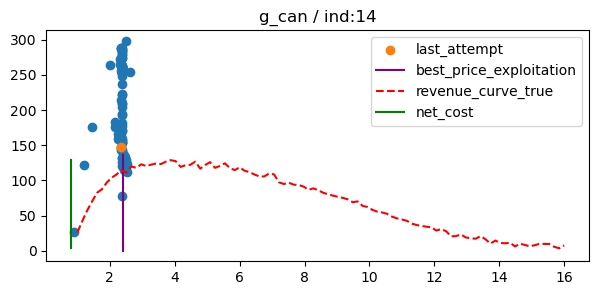

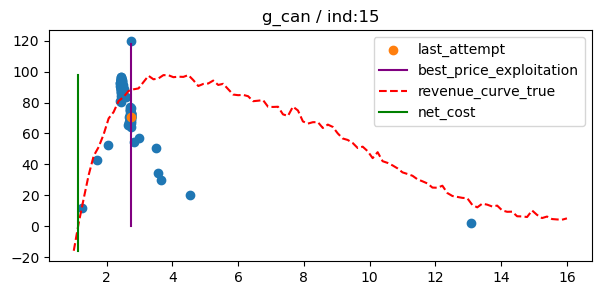

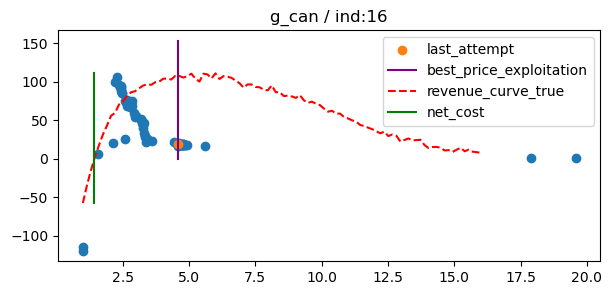

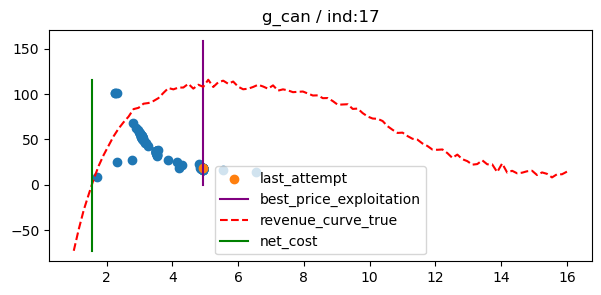

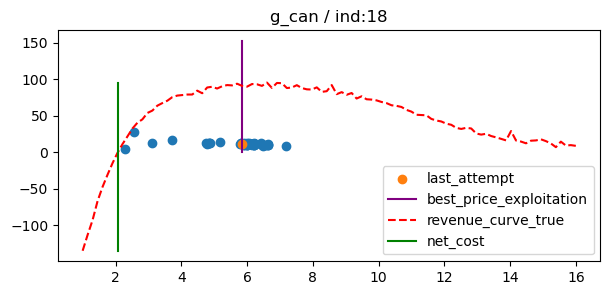

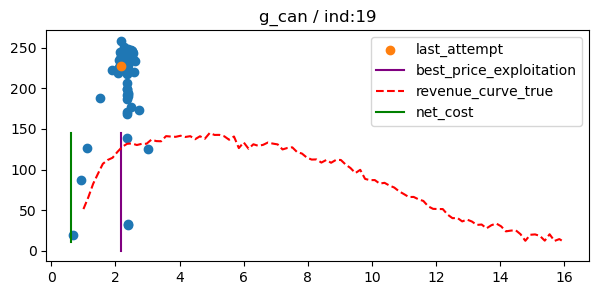

In [2103]:
plot_results_optimizer(naive, 40)

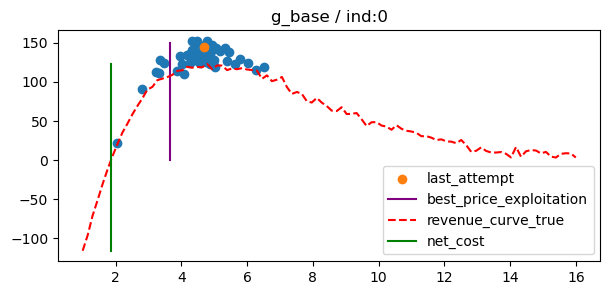

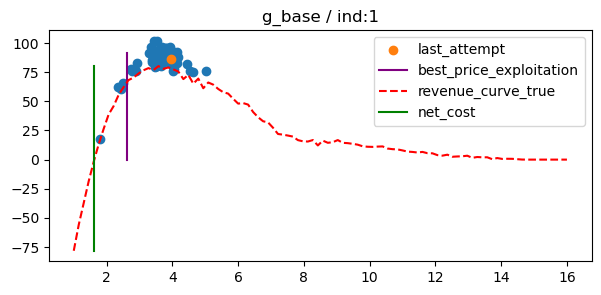

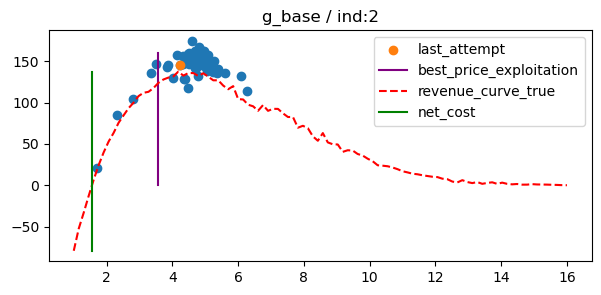

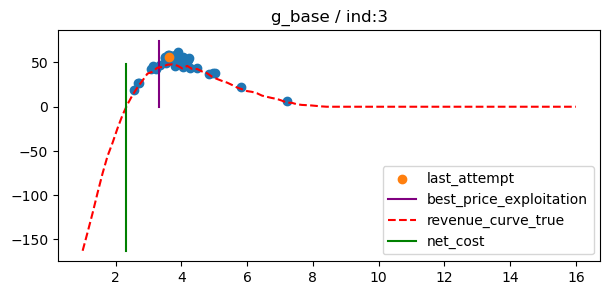

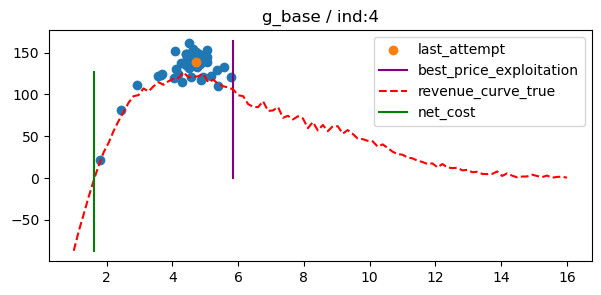

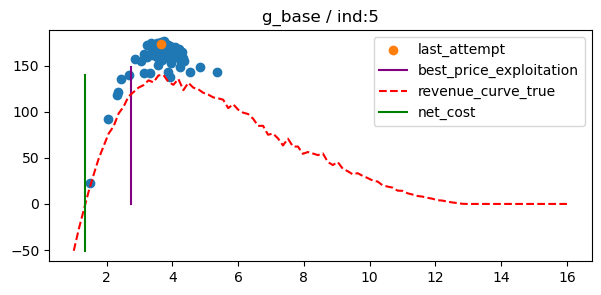

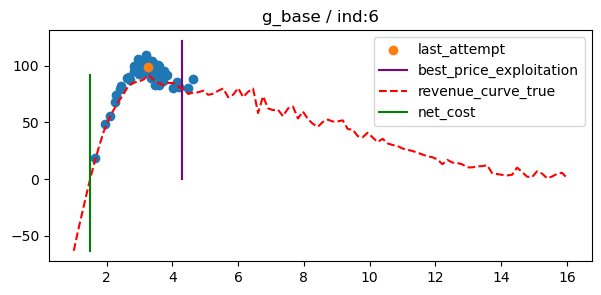

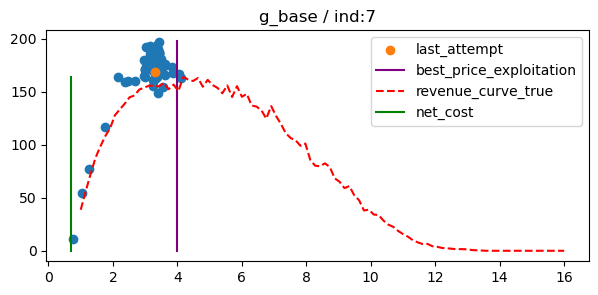

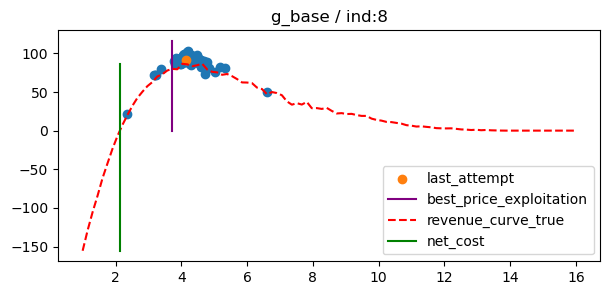

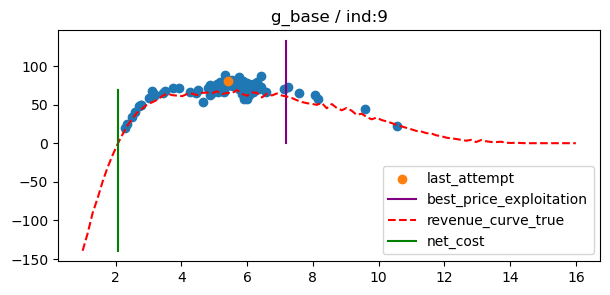

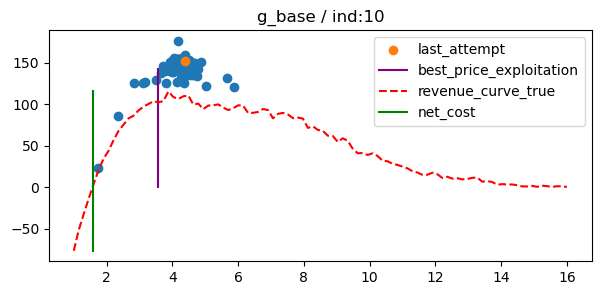

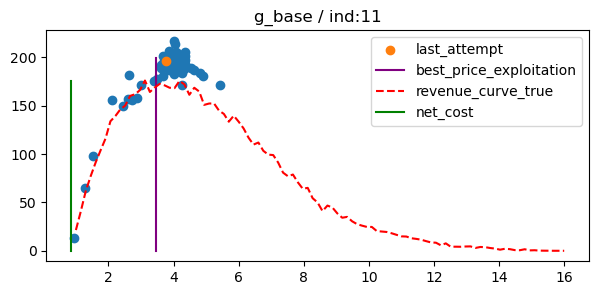

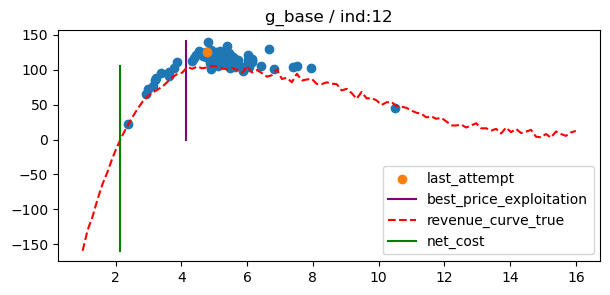

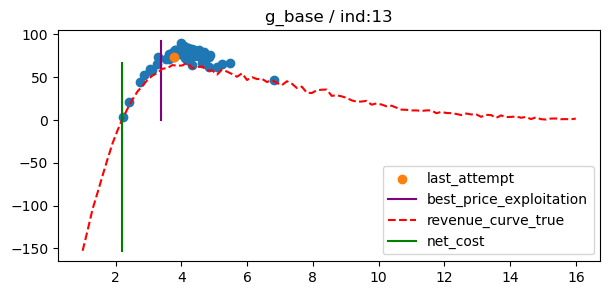

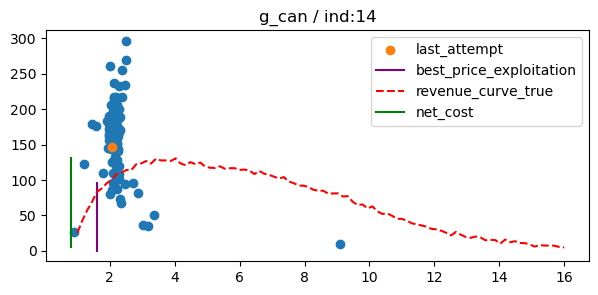

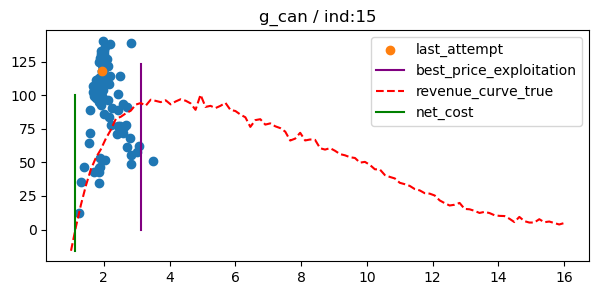

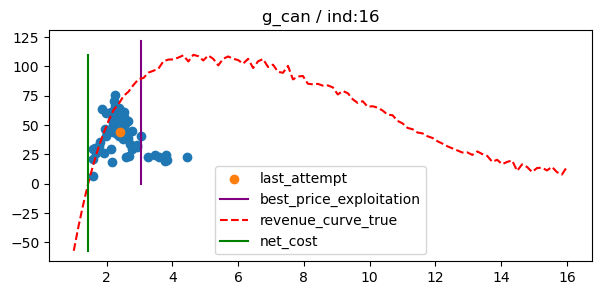

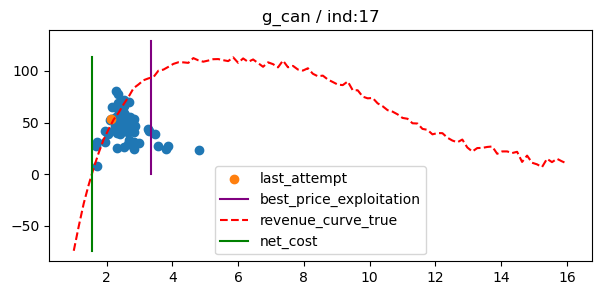

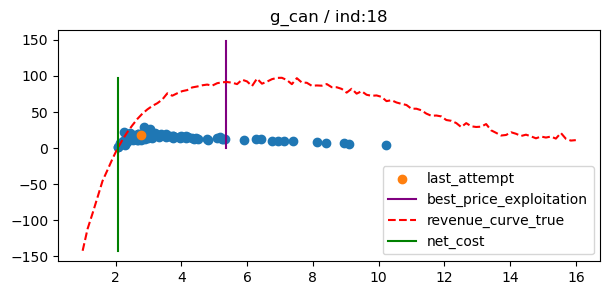

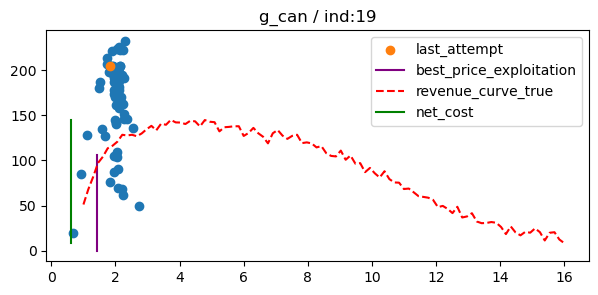

In [2104]:
plot_results_optimizer(bandit, 40,)

In [2106]:
print("Траектория BanditOptimizer хуже на ",round((1 - bandit.trajectory().sum() / naive.trajectory().sum())*100,2),"%")

Траектория BanditOptimizer хуже на  -2.07 %


## Выводы:

1. При большем числе итераций выигрывает Бандит по собранной прибыли, поскольку с какого-то момента использует лучшее решение

## Поиск оптимальных цен при изменяющемся соотношении типов агентов и изменяющемся количестве агентов

Изменение в количестве агентов регулирует функция fluctuate_population, изменяющая численность покупателей на -+10%

In [2107]:
# Пример флуктуации численности покупателей без изменения долей
env.reset_shares_types_agents()
env.fluctuate_population(1)
env.current_shares_types_agents

{'star': 0.9640842018896018,
 'collector': 0.9640842018896018,
 'independent': 0.9640842018896018,
 'base': 0.9640842018896018,
 'poor': 0.9640842018896018}

In [2120]:
%%time

naive_history_prices = {}
naive_history_trajectory = {}
bandit_history_prices = {}
bandit_history_trajectory = {}


naive = NaiveOptimizer(env, INIT_PRICES,0.2)
bandit = BanditOptimizer(env,init_prices=INIT_PRICES,every_point=0,exploration_parameter=5)

env.reset_shares_types_agents()
for n_it in [10,20,30]:
    for i in range(10):
        env.fluctuate_share_types_agents(n_it - 10 + i)
        env.fluctuate_population(n_it - 10 + i)
        naive.train(1)
        bandit.train(1)
        
    naive_history_prices[n_it] = naive.get_optimal_prices()
    naive_history_trajectory[n_it] = naive.trajectory()
    bandit_history_prices[n_it] = bandit.get_optimal_prices()
    bandit_history_trajectory[n_it] = bandit.trajectory()
    
print("last_shares_types_agents for env")
env.current_shares_types_agents

last_shares_types_agents for env
Wall time: 1.82 s


{'star': 0.8845967753275141,
 'collector': 0.948710310701216,
 'independent': 0.721869131431767,
 'base': 0.6564541510829536,
 'poor': 0.6182645626481044}

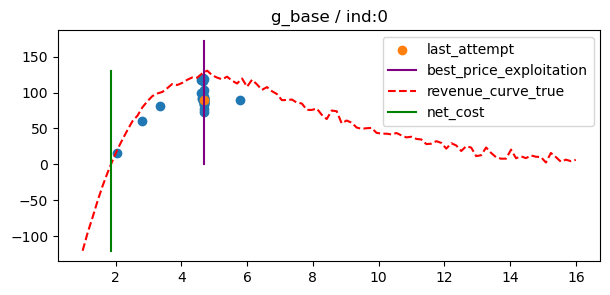

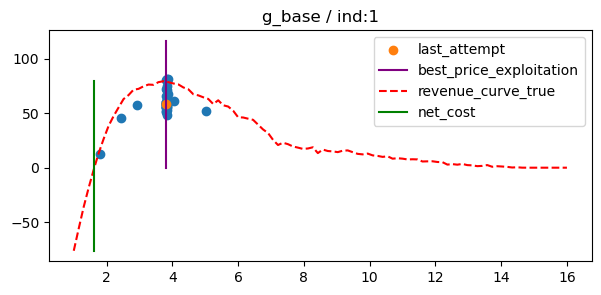

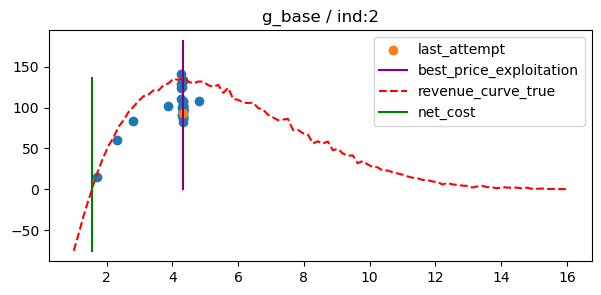

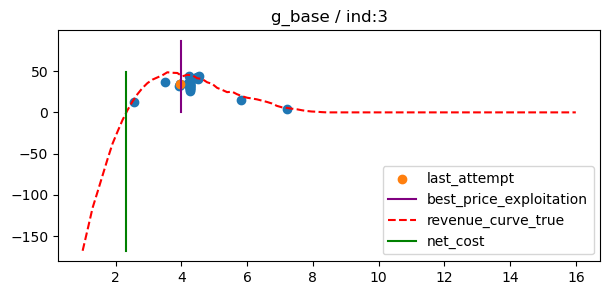

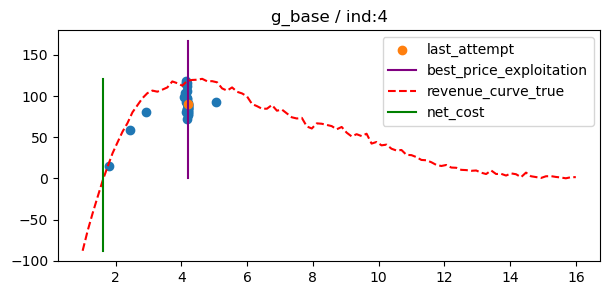

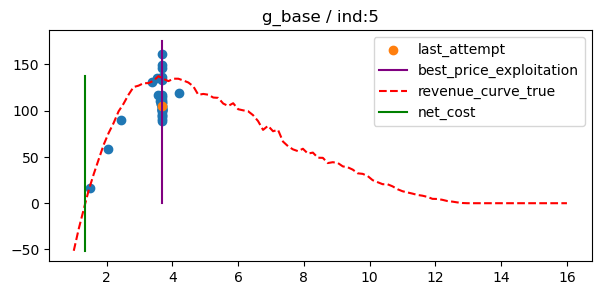

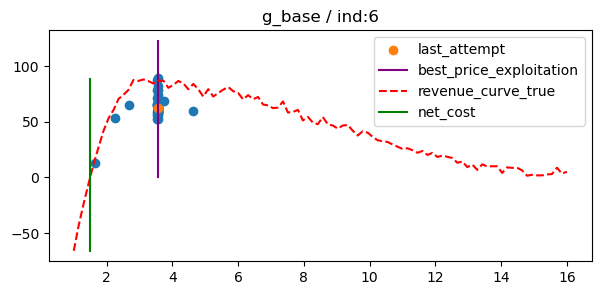

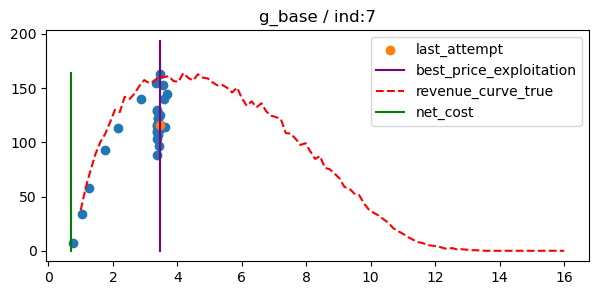

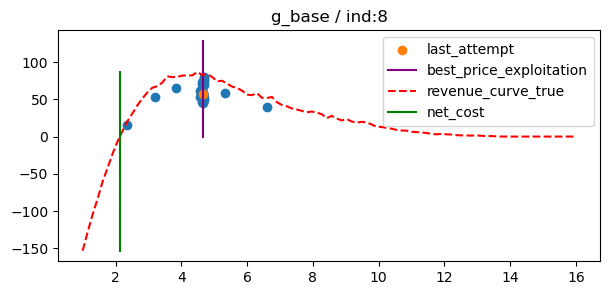

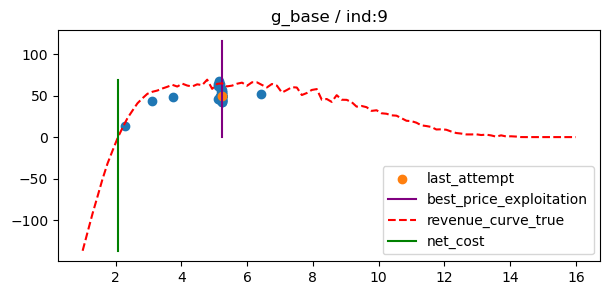

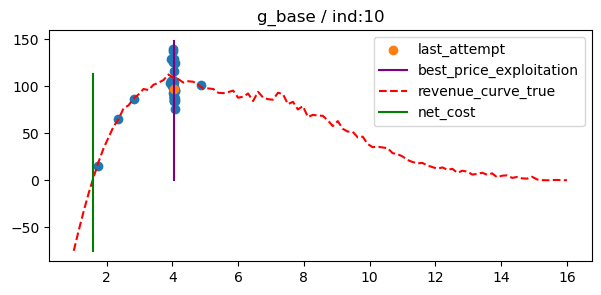

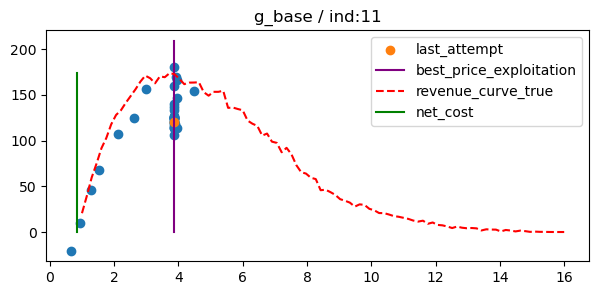

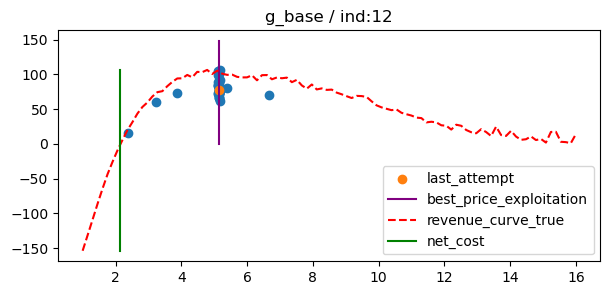

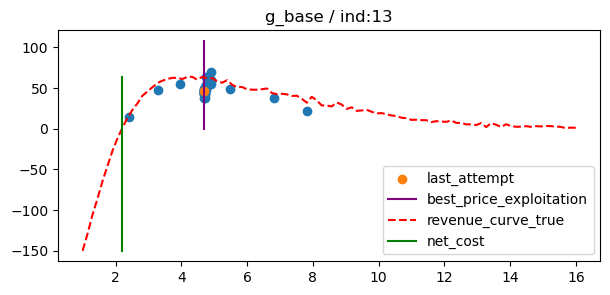

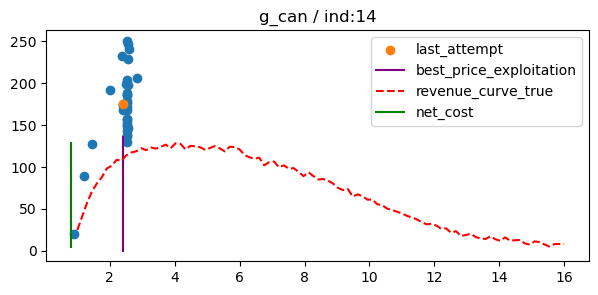

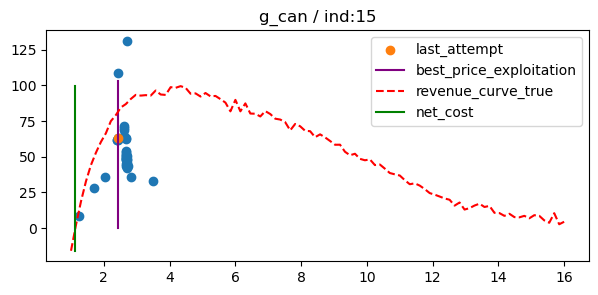

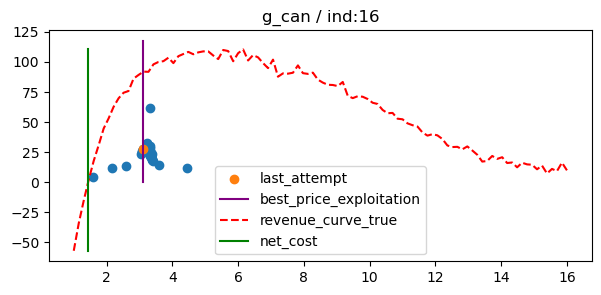

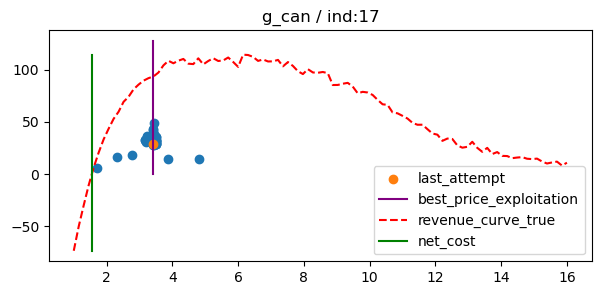

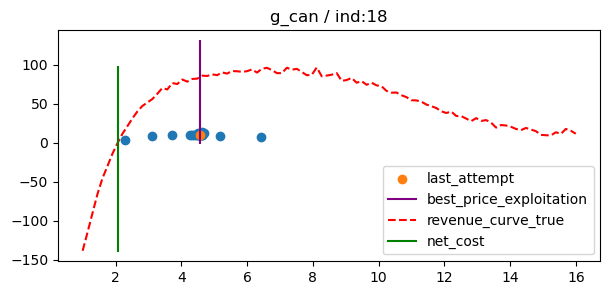

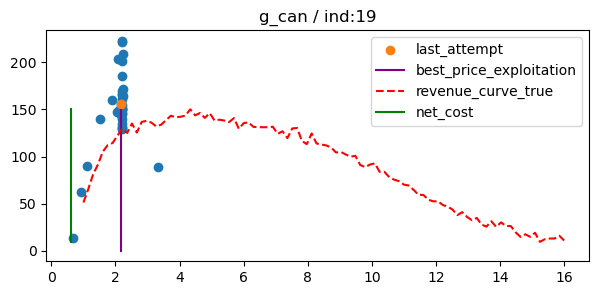

In [2121]:
plot_results_optimizer(naive, 20)

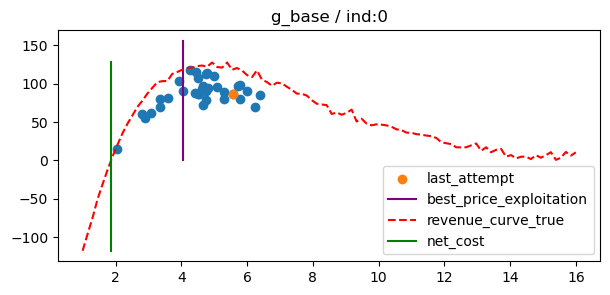

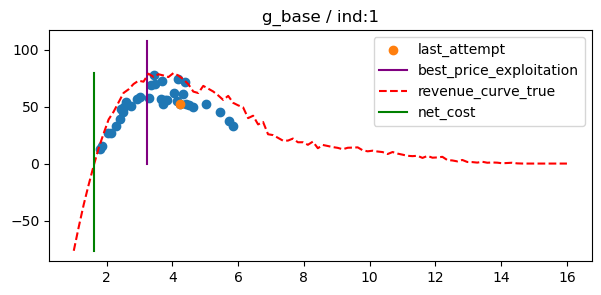

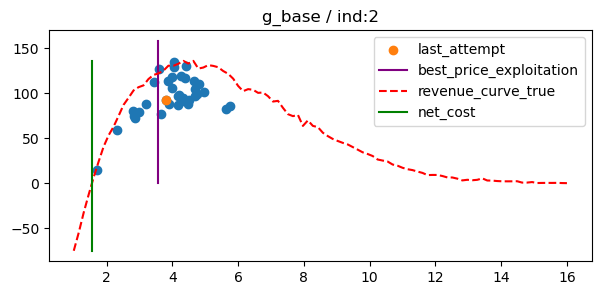

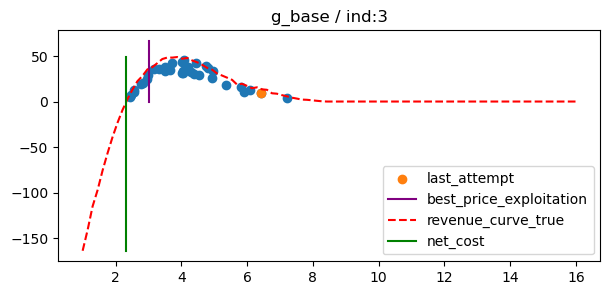

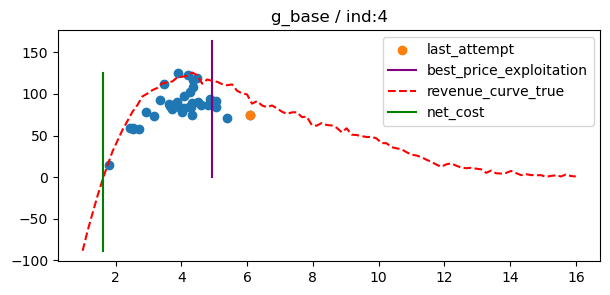

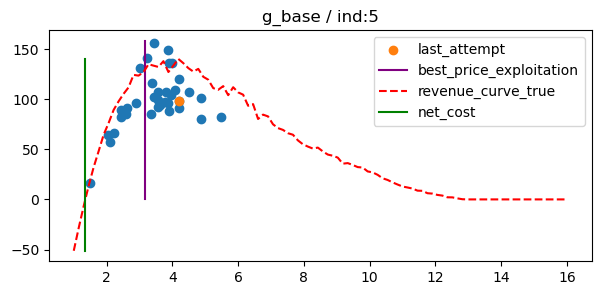

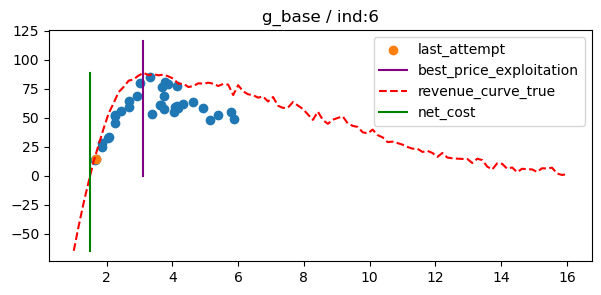

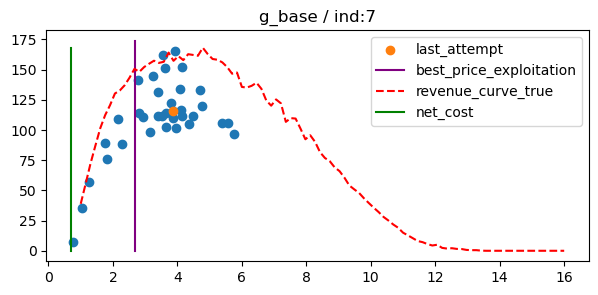

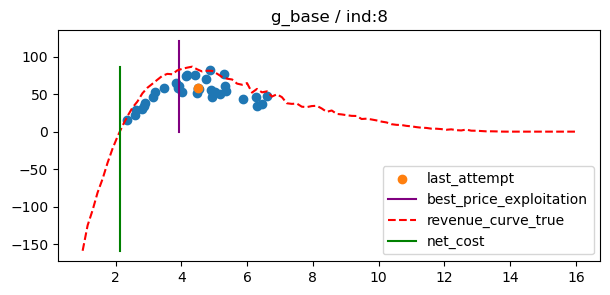

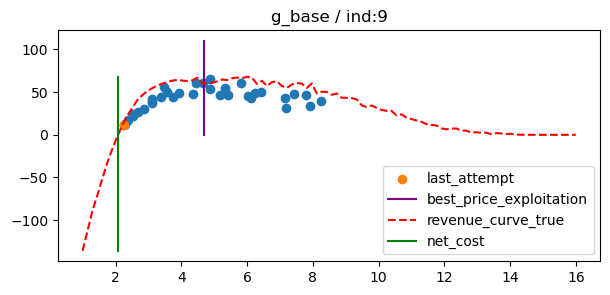

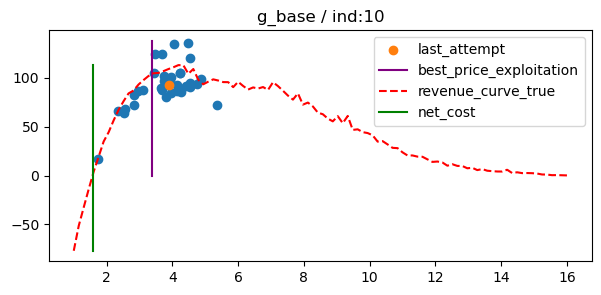

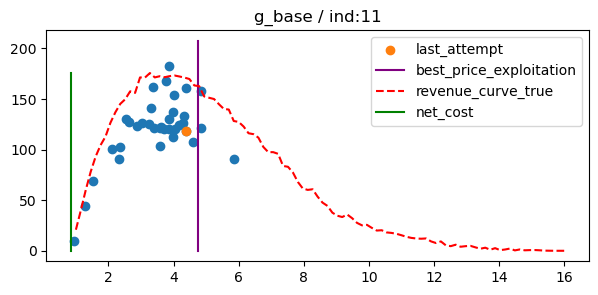

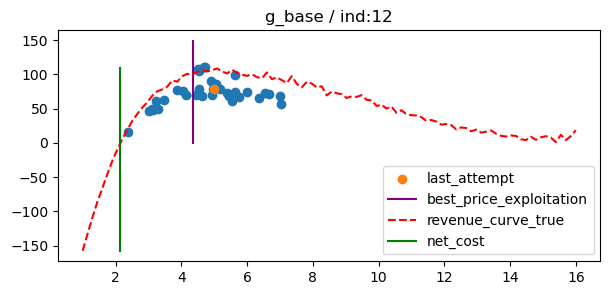

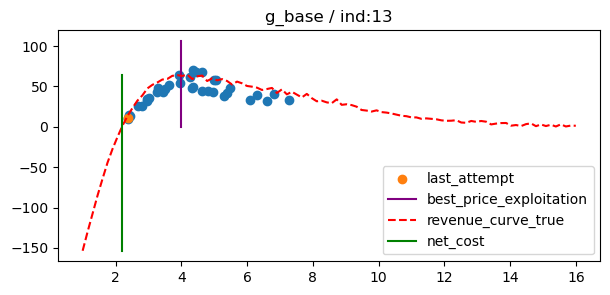

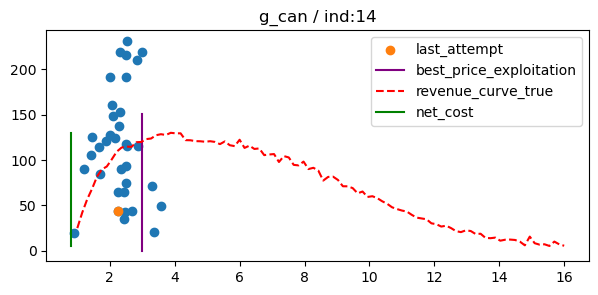

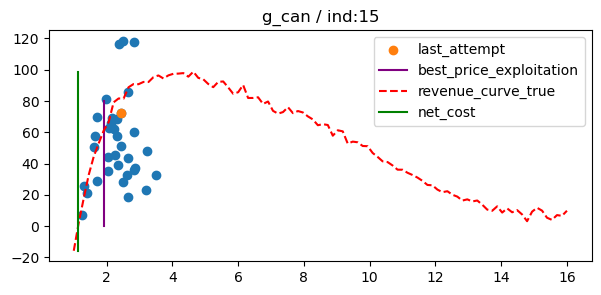

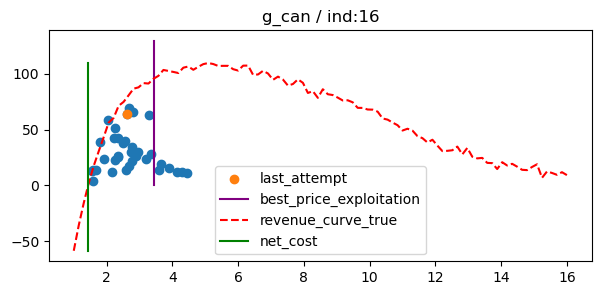

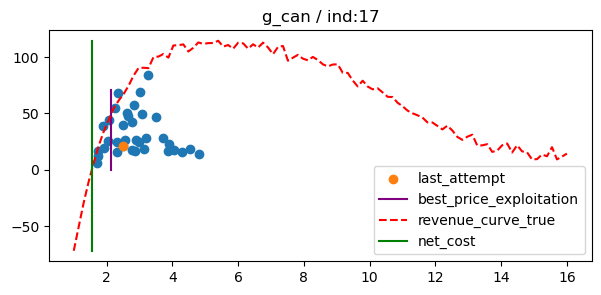

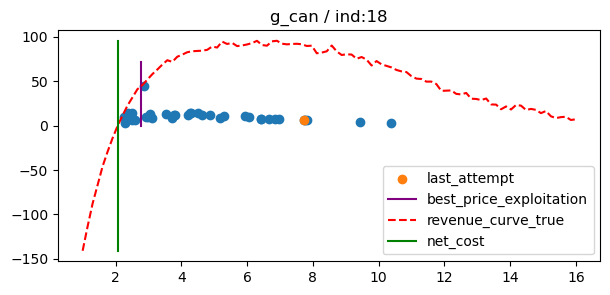

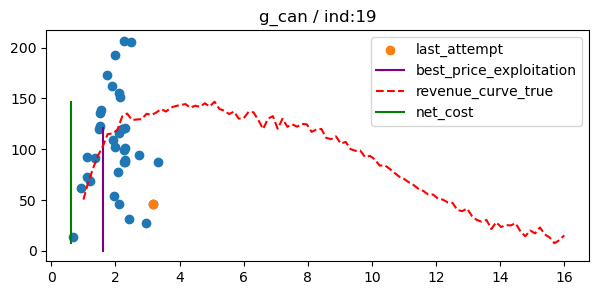

In [2122]:
plot_results_optimizer(bandit, 20,)

In [2123]:
print("Траектория BanditOptimizer хуже на ",round((1 - bandit.trajectory().sum() / naive.trajectory().sum())*100,2),"%")

Траектория BanditOptimizer хуже на  6.73 %


## Выводы:
1. При сильной динамике среды наивный побеждает по собранной прибыли.

### На 200 итерациях бандит побеждает с отрывом

In [2128]:
%%time

naive_history_prices = {}
naive_history_trajectory = {}
bandit_history_prices = {}
bandit_history_trajectory = {}


naive = NaiveOptimizer(env, INIT_PRICES)
bandit = BanditOptimizer(env,init_prices=INIT_PRICES,every_point=0,exploration_parameter=2)

env.reset_shares_types_agents()
for n_it in range(10,201,10):
    for i in range(10):
        env.fluctuate_share_types_agents(n_it - 10 + i)
        env.fluctuate_population(n_it - 10 + i)
        naive.train(1)
        bandit.train(1)
        
    naive_history_prices[n_it] = naive.get_optimal_prices()
    naive_history_trajectory[n_it] = naive.trajectory()
    bandit_history_prices[n_it] = bandit.get_optimal_prices()
    bandit_history_trajectory[n_it] = bandit.trajectory()
    
print("last_shares_types_agents for env")
env.current_shares_types_agents

last_shares_types_agents for env
Wall time: 12.3 s


{'star': 1.900206797034502,
 'collector': 1.4969065959163677,
 'independent': 0.915218180832587,
 'base': 1.1740162295263534,
 'poor': 1.4093845405192014}

In [2129]:
print("Траектория BanditOptimizer хуже на ",round((1 - bandit.trajectory().sum() / naive.trajectory().sum())*100,2),"%")

Траектория BanditOptimizer хуже на  -5.73 %


## Некоторые выводы.

Самый дешевый товар в группе каннибализирующих забирает основной спрос. Причем этот товар выбирается из самых дешевых по себестоимости.

Наивный с небольшим исследованием работает лучше, траектория цен более прибыльна для бизнеса в краткосрочной перспективе в статистическом случае. 

В динамике сравнение алгоритмов сложнее, однако и здесь наивный лучше в краткосрочном периоде, в долгосрочном бандиты за счет исследования среды побеждают.

$$\frac{\left(-e^{\left(a\cdot\left(p-4\right)\ +\ c\right)}+\frac{b}{3\log\left(1.5+p\right)}\right)}{2}$$